In [1]:
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

# import numpy as np
# np.random.seed(42)

# import tensorflow as tf
# tf.random.set_seed(42)

In [2]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

# import sys
# import warnings
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# import sklearn
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FormatStrFormatter
# import seaborn as sns

# from tensorflow import keras
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.client import device_lib
# from tensorflow.python.keras import backend as K

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     import skopt
#     import sklearn
    
#     from sklearn.preprocessing import OneHotEncoder
#     from sklearn.preprocessing import MinMaxScaler
#     from sklearn.preprocessing import StandardScaler
#     from sklearn.preprocessing import QuantileTransformer
    
#     from skopt.space import Real, Categorical, Integer
#     from skopt.utils import use_named_args
#     from skopt.plots import plot_objective, plot_evaluations
#     from skopt import gp_minimize

# print(f"Python {sys.version}")
# print()
# print(f"Pandas {pd.__version__}")
# print(f"Tensorflow {tf.__version__}")
# print(f"Keras {keras.__version__}")
# print(f"SciKit Learn {sklearn.__version__}")
# print(f"SciKit Optimize {skopt.__version__}")
# print()

# devices = device_lib.list_local_devices()

# if 'GPU' in ('').join(str(devices)):
#     print("tf accessable GPU found: "+devices[-2].physical_device_desc)

/home/siderealyear/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/siderealyear/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Python 3.7.7 (default, May  7 2020, 21:25:33) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [3]:
# import plotting_functions
import plotting_functions
import data_functions

In [4]:
def one_sample_density_plot(
    plot_location, 
    data, 
    #normalized_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
):
    values, base = np.histogram(data[data_type], bins=40)

    ax[plot_location].plot(base[:-1], (values/len(data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

def three_sample_density_plot(
    plot_location, 
    sample_1_data,
    sample_2_data,
    sample_3_data,
    data_type, 
    title, 
    xlabel, 
    ylabel, 
):
    sample_1_values, sample_1_base = np.histogram(sample_1_data[data_type], bins=40)
    sample_2_values, sample_2_base = np.histogram(sample_2_data[data_type], bins=40)
    sample_3_values, sample_3_base = np.histogram(sample_3_data[data_type], bins=40)

    ax[plot_location].plot(sample_1_base[:-1], (sample_1_values/len(sample_1_data)))
    ax[plot_location].plot(sample_2_base[:-1], (sample_2_values/len(sample_2_data)))
    ax[plot_location].plot(sample_3_base[:-1], (sample_3_values/len(sample_1_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


In [5]:
data_file = '/mnt/SSD/data/training_data/1992-2015_california_features_added.csv'

# Features to use during training 
features = [
    'lat',
    'lon',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
    'mean_ignition',
#     'total_fires',
    'date'
]

features_to_scale = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires'
]

month_dtypes = {
    'January':    'float32',
    'February':   'float32',
    'March':      'float32',
    'April':      'float32',
    'May':        'float32',
    'June':       'float32',
    'July':       'float32',
    'August':     'float32',
    'September':  'float32',
    'October':    'float32',
    'November':   'float32',
    'December':   'float32'
}

In [6]:
# Load data
raw_data = pd.read_parquet(data_file)

# Pull out columns of intrest
data = raw_data[features]

# Pick one spatial bin with fires
data = data[(data['lat'] == 39.42233) & (data['lon'] == -120.6546)]

num_fires = data['mean_ignition'].sum()
total_observations = len(data)

print("Num fires: "+str(num_fires))
print("Total obervations: "+str(total_observations))

# convert ignition to int
data['mean_ignition'] = data['mean_ignition'].astype('int')

# Also drop lat, lon, columns (unnecessary)
data.drop(['lat', 'lon'], axis=1, inplace=True)

data.reset_index(inplace=True, drop=True)
data.head()

Num fires: 716.0
Total obervations: 8766


,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,mean_vwnd_10m,mean_cloud_cover,max_air_2m,min_air_2m,mean_ignition,date
0,272.066956,0.000000,54.349842,263.759735,82468.335938,-2.419784,3.027377,4.875000,278.654724,269.370331,0,1992-01-01
1,273.152374,0.000343,46.536934,262.851501,82450.710938,-1.904384,3.347039,5.640625,278.771637,270.165314,0,1992-01-02
2,274.637451,0.020557,43.627312,263.381226,81925.929688,-1.495060,1.557715,40.312500,279.329834,271.714264,0,1992-01-03
3,273.870850,0.898149,73.530479,269.089813,81348.601562,1.027952,6.304882,151.531250,275.773804,272.108826,0,1992-01-04
4,273.817963,2.706949,93.832382,272.896027,81021.375000,1.164567,11.754253,199.000000,274.953461,272.592834,0,1992-01-05


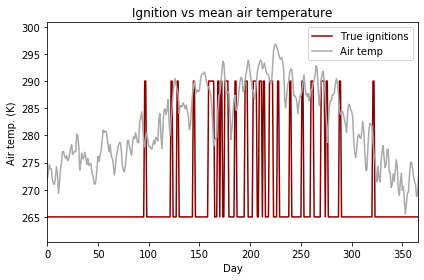

In [7]:
plotting_functions.data_diagnostic_plot(data, 'mean_air_2m', 25, 265)

In [8]:
onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)
month = month.astype('int')
onehot_month = onehot_encoder.fit_transform(month).astype('int32')
onehot_month_df = pd.DataFrame(onehot_month, columns = month_dtypes.keys())
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int')
data.reset_index(drop = True, inplace = True)
data = pd.concat([data, onehot_month_df], axis = 1)
data.drop('date', axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_air_2m       8766 non-null   float32
 1   mean_apcp         8766 non-null   float32
 2   mean_rhum_2m      8766 non-null   float32
 3   mean_dpt_2m       8766 non-null   float32
 4   mean_pres_sfc     8766 non-null   float32
 5   mean_uwnd_10m     8766 non-null   float32
 6   mean_vwnd_10m     8766 non-null   float32
 7   mean_cloud_cover  8766 non-null   float32
 8   max_air_2m        8766 non-null   float32
 9   min_air_2m        8766 non-null   float32
 10  mean_ignition     8766 non-null   int64  
 11  January           8766 non-null   int64  
 12  February          8766 non-null   int64  
 13  March             8766 non-null   int64  
 14  April             8766 non-null   int64  
 15  May               8766 non-null   int64  
 16  June              8766 non-null   int64  


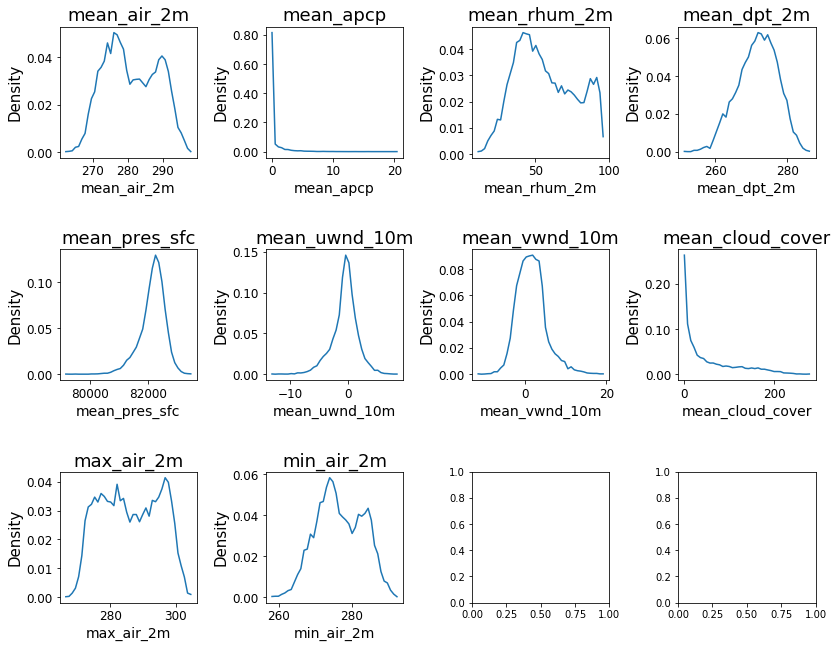

In [9]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 3
fig_cols = 4
plot_height = 10
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1)#,(2,2),(2,3),
#     (3,0),(3,1),(3,2),(3,3),
#     (4,0),(4,1),(4,2),(4,3),
#     (5,0),(5,1),(5,2),(5,3),
#     (6,0),(6,1),(6,2)
]

data_types = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires'
]

xlabels = data_types
ylabels = ['Density'] * len(data_types)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = one_sample_density_plot(plot_locations[i], data, data_types[i], data_types[i], data_types[i], ylabels[i])

In [10]:
qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
normalized_data = pd.DataFrame(qt.fit_transform(data[features_to_scale]), columns=features_to_scale)
data[features_to_scale] = normalized_data

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

data[features_to_scale] = data[features_to_scale].astype('float32')

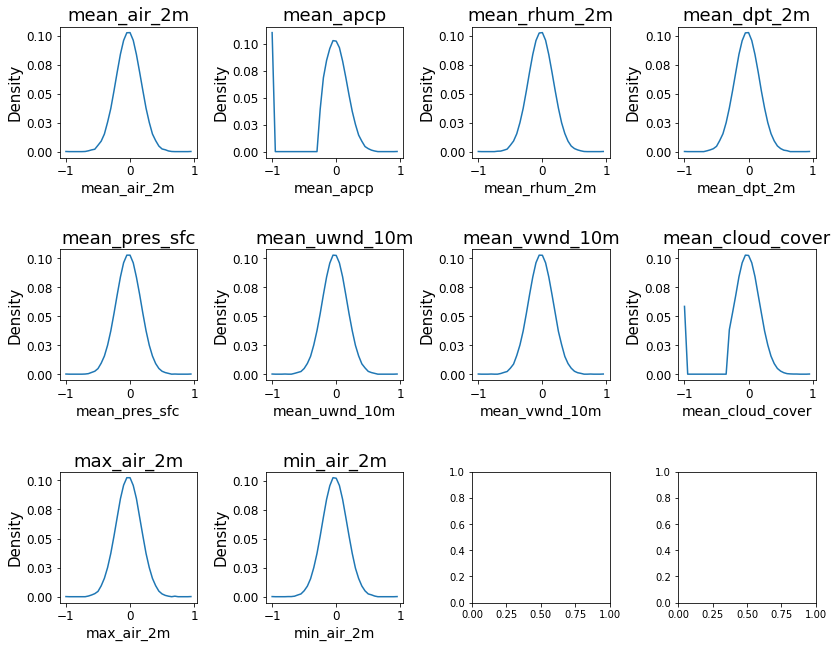

In [11]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 3
fig_cols = 4
plot_height = 10
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1)#,(2,2),(2,3),
#     (3,0),(3,1),(3,2),(3,3),
#     (4,0),(4,1),(4,2),(4,3),
#     (5,0),(5,1),(5,2),(5,3),
#     (6,0),(6,1),(6,2)
]

data_types = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
    'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
    'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires'
]

xlabels = data_types
ylabels = ['Density'] * len(data_types)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = one_sample_density_plot(plot_locations[i], data, data_types[i], data_types[i], data_types[i], ylabels[i])
    
plt.show()

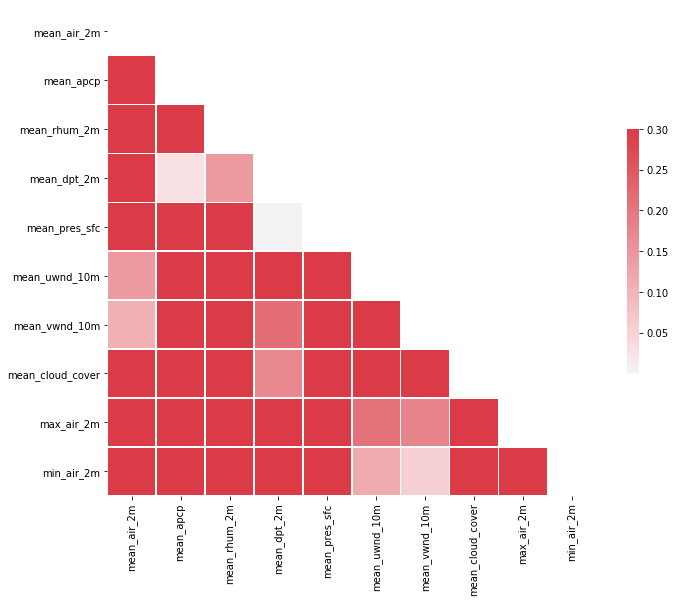

In [12]:
corr = data[features_to_scale].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [13]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [14]:
to_drop

['max_air_2m', 'min_air_2m']

In [15]:
data = data.drop(data[to_drop], axis=1)

In [16]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.25))
leftover_data = data.head(int(len(data)*0.75))
validation_data = data.tail(int(len(leftover_data)*0.5))
training_data = data.head(int(len(leftover_data)*0.5))

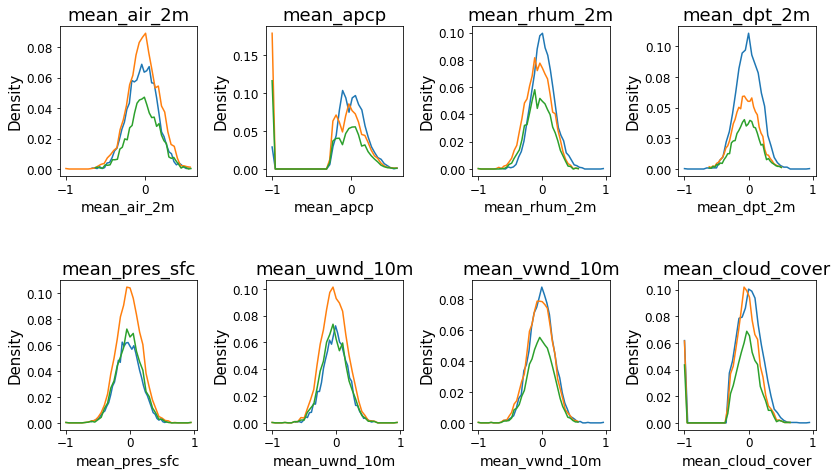

In [17]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 2
fig_cols = 4
plot_height = 7
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
#    (2,0),(2,1),(2,2),(2,3),
#     (3,0),(3,1),(3,2),(3,3),
#     (4,0),(4,1),(4,2),(4,3),
#     (5,0),(5,1),(5,2),(5,3),
#     (6,0),(6,1),(6,2)
]

data_types = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
#     'mean_vis',
    'mean_cloud_cover',
#     'max_air_2m',
#     'max_apcp',
#     'max_rhum_2m',
#     'max_dpt_2m',
#     'max_pres_sfc',
#     'max_uwnd_10m',
#     'max_vwnd_10m',
#     'max_vis',
#     'max_cloud_cover',
#     'min_air_2m',
#     'min_apcp',
#     'min_rhum_2m',
#     'min_dpt_2m',
#     'min_pres_sfc',
#     'min_uwnd_10m',
#     'min_vwnd_10m',
#     'min_vis',
#     'min_cloud_cover',
#     'total_fires'
]

# reshaped_training_data = training_data.reshape(training_data.shape[1], training_data.shape[0])
# reshaped_validation_data = validation_data.reshape(validation_data.shape[1], validation_data.shape[0])
# reshaped_test_data = test_data.reshape(test_data.shape[1], test_data.shape[0])

xlabels = data_types
ylabels = ['Density'] * len(data_types)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = three_sample_density_plot(
        plot_locations[i], 
        training_data, 
        validation_data, 
        test_data, 
        data_types[i], 
        data_types[i], 
        data_types[i], 
        ylabels[i]
    )
    
plt.show()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_air_2m       8766 non-null   float32
 1   mean_apcp         8766 non-null   float32
 2   mean_rhum_2m      8766 non-null   float32
 3   mean_dpt_2m       8766 non-null   float32
 4   mean_pres_sfc     8766 non-null   float32
 5   mean_uwnd_10m     8766 non-null   float32
 6   mean_vwnd_10m     8766 non-null   float32
 7   mean_cloud_cover  8766 non-null   float32
 8   mean_ignition     8766 non-null   int64  
 9   January           8766 non-null   int64  
 10  February          8766 non-null   int64  
 11  March             8766 non-null   int64  
 12  April             8766 non-null   int64  
 13  May               8766 non-null   int64  
 14  June              8766 non-null   int64  
 15  July              8766 non-null   int64  
 16  August            8766 non-null   int64  


In [19]:
# Convert to numpy arrays
training_data = np.array(training_data)
training_labels = training_data[:, -13]
training_data = np.delete(training_data, -13, 1)

validation_data = np.array(validation_data)
validation_labels = validation_data[:, -13]
validation_data = np.delete(validation_data, -13, 1)

test_data = np.array(test_data)
test_labels = test_data[:, -13]
test_data = np.delete(test_data, -13, 1)

In [20]:
print(type(training_data))
print(type(validation_data))
print(type(test_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### First, let's try and over fit the crap out of it with a 100 unit LSTM. We will use Gaussian process minimization to optimize the learning rate, past history and class weights. Loss function is binary cross entropy. Minimization and early stopping will use Matthews correlation coefficient.

In [25]:
future_target = 1
step = 1
past_history = 5

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

EPOCHS = 50

path_best_model = '../../trained_models/first_round_skopt_single_statefull_LTSM_CA_only.keras'
best_matthews_correlation = -1.0

metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

# dim_past_history = Integer(
#     low=1,
#     high=5, 
#     name='past_history'
# )

dim_class_0_weight = Real(
    low=0.001, 
    high=10,
    name='class_0_weight'
)

dim_class_1_weight = Real(
    low=0.01, 
    high=100,
    name='class_1_weight'
)

inital_class_0_weight = (1 / (total_observations - num_fires))*(total_observations)/2.0 
inital_class_1_weight = (1 / num_fires)*(total_observations)/2.0

default_parameters = [0.1, inital_class_0_weight, inital_class_1_weight]

dimensions = [
    dim_learning_rate,
#     dim_past_history,
    dim_class_0_weight,
    dim_class_1_weight
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'matthews_correlation', 
    patience = 5,
    mode = 'min',
    restore_best_weights = True
)

run_num = 1

In [26]:
def make_model(
    input_shape,
    learning_rate
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        100,
        batch_input_shape = input_shape,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
#     past_history,
    class_0_weight,
    class_1_weight
):

    # Print the hyper-parameters.
    print('learning rate:', learning_rate)
#     print('past history:', past_history)
    print('class 0 weight:', class_0_weight)
    print('class 1 weight:', class_1_weight)
    print()
    
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    # create data 
    x_train, y_train = data_functions.multivariate_data(
        training_data, 
        training_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data, 
        validation_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    class_weight = {0: class_0_weight, 1: class_1_weight} # tensorflow 2.2
    #class_weight = [class_0_weight, class_1_weight] # tensorflow 2.1
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape,
        learning_rate
    )
    
    model.summary()
    print()
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8
        #verbose=0
    )

    matthews_correlation = history.history['matthews_correlation'][-1]
    
    print()
    print()
    print(f"Run {run_num} final matthews correlation: {matthews_correlation}")
    print()
    
    run_num += 1

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the classification accuracy of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -matthews_correlation

In [27]:
%%time

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=100,
    x0=default_parameters
)

learning rate: 0.1
class 0 weight: 0.544472049689441
class 1 weight: 6.121508379888269

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 1.4234 - true_positives: 56.0000 - false_positives: 412.0000 - true_negatives: 2565.0000 - false_negatives: 217.0000 - auc: 0.5139 - matthews_correlation: 0.0368 - val_loss: 0.8834 - val_true_positives: 89.0000 - val_false_positives: 1123.0000 - val

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 2.9032 - true_positives: 41.0000 - false_positives: 204.0000 - true_negatives: 2773.0000 - false_negatives: 232.0000 - auc: 0.5055 - matthews_correlation: 0.0501 - val_loss: 2.1921 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5924 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 2.0783 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7089 - matthews_correlation: 0.0000e+00 - val_loss: 1.8607 - val_true_positives: 3.0000 - val_false_positives: 15.0000 - val_true_negatives: 2975.0000 - val_false_negatives: 257.0000 - val_auc: 0.7656 - val_matthews_correlation: 0.0339
Epoch 3/50
3250/3250 [============

Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 2.1491 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5412 - matthews_correlation: 0.0000e+00 - val_loss: 1.9134 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5234 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 2.1276 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.4725 - matthews_correlation: 0.0000e+00 - val_loss: 1.9429 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 28us/sample - loss: 1.9085 

Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 0.3873 - true_positives: 0.0000e+00 - false_positives: 5.0000 - true_negatives: 2972.0000 - false_negatives: 273.0000 - auc: 0.6931 - matthews_correlation: -0.0055 - val_loss: 0.3026 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7353 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 0.3075 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7910 - matthews_correlation: 0.0000e+00 - val_loss: 0.2973 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7656 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 0.3037 - true_

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 4.9782 - true_positives: 10.0000 - false_positives: 39.0000 - true_negatives: 2938.0000 - false_negatives: 263.0000 - auc: 0.7003 - matthews_correlation: 0.0216 - val_loss: 6.4567 - val_true_positives: 137.0000 - val_false_positives: 950.0000 - val_true_negatives: 2040.0000 - val_false_negatives: 123.0000 - val_auc: 0.6544 - val_matthews_correlation: 0.1177
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 5.1198 - true_positives: 63.0000 - false_positives: 338.0000 - true_negatives: 2639.0000 - false_negatives: 210.0000 - auc: 0.7010 - matthews_correlation: 0.0681 - val_loss: 4.4487 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7877 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [===================

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 18.9211 - true_positives: 56.0000 - false_positives: 417.0000 - true_negatives: 2560.0000 - false_negatives: 217.0000 - auc: 0.5299 - matthews_correlation: 0.0496 - val_loss: 8.6187 - val_true_positives: 88.0000 - val_false_positives: 1026.0000 - val_true_negatives: 1964.0000 - val_false_negatives: 172.0000 - val_auc: 0.4920 - val_matthews_correlation: -0.0017
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 8.0314 - true_positives: 210.0000 - false_positives: 1823.0000 - true_negatives: 1154.0000 - false_negatives: 63.0000 - auc: 0.5713 - matthews_correlation: 0.0936 - val_loss: 6.6526 - val_true_positives: 248.0000 - val_false_positives: 2028.0000 - val_true_negatives: 962.0000 - val_false_negatives: 12.0000 - val_auc: 0.7328 - val_matthews_correlation: 0.1612
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample 

Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 9.4252 - true_positives: 2.0000 - false_positives: 4.0000 - true_negatives: 2973.0000 - false_negatives: 271.0000 - auc: 0.7329 - matthews_correlation: 0.0178 - val_loss: 7.2698 - val_true_positives: 134.0000 - val_false_positives: 1217.0000 - val_true_negatives: 1773.0000 - val_false_negatives: 126.0000 - val_auc: 0.5915 - val_matthews_correlation: 0.0519
Epoch 3/50
3250/3250 [==============================] - 0s 27us/sample - loss: 7.1996 - true_positives: 234.0000 - false_positives: 1837.0000 - true_negatives: 1140.0000 - false_negatives: 39.0000 - auc: 0.6800 - matthews_correlation: 0.1476 - val_loss: 6.7911 - val_true_positives: 36.0000 - val_false_positives: 178.0000 - val_true_negatives: 2812.0000 - val_false_negatives: 224.0000 - val_auc: 0.7276 - val_matthews_correlation: 0.0877
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 7.0974 - true_positives: 13.0000 - false_po

Epoch 5/50
3250/3250 [==============================] - 0s 26us/sample - loss: 5.5033 - true_positives: 236.0000 - false_positives: 935.0000 - true_negatives: 2042.0000 - false_negatives: 37.0000 - auc: 0.8143 - matthews_correlation: 0.3182 - val_loss: 5.8918 - val_true_positives: 211.0000 - val_false_positives: 1024.0000 - val_true_negatives: 1966.0000 - val_false_negatives: 49.0000 - val_auc: 0.7860 - val_matthews_correlation: 0.2551
Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 5.3398 - true_positives: 240.0000 - false_positives: 964.0000 - true_negatives: 2013.0000 - false_negatives: 33.0000 - auc: 0.8202 - matthews_correlation: 0.3186 - val_loss: 6.1379 - val_true_positives: 227.0000 - val_false_positives: 1180.0000 - val_true_negatives: 1810.0000 - val_false_negatives: 33.0000 - val_auc: 0.7892 - val_matthews_correlation: 0.2570


Run 17 final matthews correlation: 0.3185795843601227

learning rate: 0.0882159184447951
class 0 weight: 1.81526575359

learning rate: 0.07039127879319344
class 0 weight: 2.539397427087317
class 1 weight: 28.562684112904723

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 5.5765 - true_positives: 60.0000 - false_positives: 340.0000 - true_negatives: 2637.0000 - false_negatives: 213.0000 - auc: 0.5413 - matthews_correlation: 0.0650 - val_loss: 3.9533 - val_true_positives: 95.0000 - val_false_positives

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 10.0881 - true_positives: 55.0000 - false_positives: 311.0000 - true_negatives: 2666.0000 - false_negatives: 218.0000 - auc: 0.5436 - matthews_correlation: 0.0686 - val_loss: 6.9566 - val_true_positives: 143.0000 - val_false_positives: 1179.0000 - val_true_negatives: 1811.0000 - val_false_negatives: 117.0000 - val_auc: 0.6008 - val_mat

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 9.0196 - true_positives: 67.0000 - false_positives: 567.0000 - true_negatives: 2410.0000 - false_negatives: 206.0000 - auc: 0.5599 - matthews_correlation: 0.0411 - val_loss: 4.4444 - val_true_positives: 2.0000 - val_false_positives: 29.0000 - val_true_negatives: 2961.0000 - val_false_negatives: 258.0000 - val_auc: 0.6814 - val_matthews

3250/3250 [==============================] - 0s 26us/sample - loss: 2.1723 - true_positives: 224.0000 - false_positives: 1341.0000 - true_negatives: 1636.0000 - false_negatives: 49.0000 - auc: 0.7574 - matthews_correlation: 0.2214 - val_loss: 2.1777 - val_true_positives: 249.0000 - val_false_positives: 1798.0000 - val_true_negatives: 1192.0000 - val_false_negatives: 11.0000 - val_auc: 0.7828 - val_matthews_correlation: 0.1958
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 1.9922 - true_positives: 229.0000 - false_positives: 1085.0000 - true_negatives: 1892.0000 - false_negatives: 44.0000 - auc: 0.8081 - matthews_correlation: 0.2720 - val_loss: 1.9624 - val_true_positives: 216.0000 - val_false_positives: 987.0000 - val_true_negatives: 2003.0000 - val_false_negatives: 44.0000 - val_auc: 0.7908 - val_matthews_correlation: 0.2752
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 1.8571 - true_positives: 237.0000 - false_positives

3250/3250 [==============================] - 0s 27us/sample - loss: 4.6071 - true_positives: 260.0000 - false_positives: 1395.0000 - true_negatives: 1582.0000 - false_negatives: 13.0000 - auc: 0.7980 - matthews_correlation: 0.2696 - val_loss: 4.8461 - val_true_positives: 245.0000 - val_false_positives: 1472.0000 - val_true_negatives: 1518.0000 - val_false_negatives: 15.0000 - val_auc: 0.7754 - val_matthews_correlation: 0.2411
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 4.3836 - true_positives: 261.0000 - false_positives: 1390.0000 - true_negatives: 1587.0000 - false_negatives: 12.0000 - auc: 0.8031 - matthews_correlation: 0.2722 - val_loss: 4.6566 - val_true_positives: 245.0000 - val_false_positives: 1405.0000 - val_true_negatives: 1585.0000 - val_false_negatives: 15.0000 - val_auc: 0.7884 - val_matthews_correlation: 0.2534
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 4.2172 - true_positives: 256.0000 - false_positive

3250/3250 [==============================] - 0s 26us/sample - loss: 0.0099 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 0.0102 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
3250/3250 [==============================] - 0s 26us/sample - loss: 0.0102 - true_positives: 273.0000 - false_positives: 2977.0000 - true_negatives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 0.0104 - val_true_positives: 260.0000 - val_false_positives: 2990.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00


Run 34 final matthews correlation: 0.0

learning rate: 0.0001
class 0 weight: 2.770481404274309

Epoch 7/50
3250/3250 [==============================] - 0s 27us/sample - loss: 2.1051 - true_positives: 250.0000 - false_positives: 1101.0000 - true_negatives: 1876.0000 - false_negatives: 23.0000 - auc: 0.8170 - matthews_correlation: 0.3075 - val_loss: 2.3334 - val_true_positives: 228.0000 - val_false_positives: 1172.0000 - val_true_negatives: 1818.0000 - val_false_negatives: 32.0000 - val_auc: 0.7792 - val_matthews_correlation: 0.2617


Run 36 final matthews correlation: 0.30745914578437805

learning rate: 0.08600156411273101
class 0 weight: 7.347624217726847
class 1 weight: 78.73153070267986

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
N

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 10.7327 - true_positives: 91.0000 - false_positives: 624.0000 - true_negatives: 2353.0000 - false_negatives: 182.0000 - auc: 0.6517 - matthews_correlation: 0.1127 - val_loss: 6.8702 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6215 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 7.0860 - true_positives: 101.0000 - false_positives: 1042.0000 - true_negatives: 1935.0000 - false_negatives: 172.0000 - auc: 0.5550 - matthews_correlation: 0.0154 - val_loss: 6.5855 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7511 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [=======

Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 0.0126 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 0.0071 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 27us/sample - loss: 0.0088 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 0.0084 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 0.0093 

Epoch 3/50
3250/3250 [==============================] - 0s 25us/sample - loss: 3.1920 - true_positives: 18.0000 - false_positives: 53.0000 - true_negatives: 2924.0000 - false_negatives: 255.0000 - auc: 0.7136 - matthews_correlation: 0.0530 - val_loss: 2.5870 - val_true_positives: 198.0000 - val_false_positives: 1074.0000 - val_true_negatives: 1916.0000 - val_false_negatives: 62.0000 - val_auc: 0.7599 - val_matthews_correlation: 0.2206
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 2.4506 - true_positives: 226.0000 - false_positives: 994.0000 - true_negatives: 1983.0000 - false_negatives: 47.0000 - auc: 0.7956 - matthews_correlation: 0.2832 - val_loss: 2.5354 - val_true_positives: 190.0000 - val_false_positives: 891.0000 - val_true_negatives: 2099.0000 - val_false_negatives: 70.0000 - val_auc: 0.7722 - val_matthews_correlation: 0.2416
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 2.2841 - true_positives: 224.0000 - false_p

3250/3250 [==============================] - 0s 26us/sample - loss: 7.4296 - true_positives: 232.0000 - false_positives: 926.0000 - true_negatives: 2051.0000 - false_negatives: 41.0000 - auc: 0.8225 - matthews_correlation: 0.3124 - val_loss: 8.1480 - val_true_positives: 237.0000 - val_false_positives: 1238.0000 - val_true_negatives: 1752.0000 - val_false_negatives: 23.0000 - val_auc: 0.7917 - val_matthews_correlation: 0.2683
Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 7.3264 - true_positives: 251.0000 - false_positives: 1077.0000 - true_negatives: 1900.0000 - false_negatives: 22.0000 - auc: 0.8206 - matthews_correlation: 0.3143 - val_loss: 8.0707 - val_true_positives: 224.0000 - val_false_positives: 1157.0000 - val_true_negatives: 1833.0000 - val_false_negatives: 36.0000 - val_auc: 0.7887 - val_matthews_correlation: 0.2553


Run 47 final matthews correlation: 0.3142583966255188

learning rate: 0.1
class 0 weight: 4.093895770148465
class 1 weight: 51.3

learning rate: 0.039148444632123226
class 0 weight: 1.7894454875281718
class 1 weight: 22.72759467452666

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 903us/sample - loss: 3.9740 - true_positives: 106.0000 - false_positives: 988.0000 - true_negatives: 1989.0000 - false_negatives: 167.0000 - auc: 0.6007 - matthews_correlation: 0.0550 - val_loss: 2.7202 - val_true_positives: 0.0000e+00 - val_false_po

3250/3250 [==============================] - 3s 907us/sample - loss: 9.8117 - true_positives: 124.0000 - false_positives: 1004.0000 - true_negatives: 1973.0000 - false_negatives: 149.0000 - auc: 0.6333 - matthews_correlation: 0.0775 - val_loss: 6.8590 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7721 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 6.9124 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.8015 - matthews_correlation: 0.0000e+00 - val_loss: 5.4939 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7783 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 5.0851 - true_positives:

3250/3250 [==============================] - 0s 29us/sample - loss: 11.3235 - true_positives: 60.0000 - false_positives: 232.0000 - true_negatives: 2745.0000 - false_negatives: 213.0000 - auc: 0.7351 - matthews_correlation: 0.0949 - val_loss: 9.3891 - val_true_positives: 241.0000 - val_false_positives: 1494.0000 - val_true_negatives: 1496.0000 - val_false_negatives: 19.0000 - val_auc: 0.7675 - val_matthews_correlation: 0.2275
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 9.2866 - true_positives: 259.0000 - false_positives: 1534.0000 - true_negatives: 1443.0000 - false_negatives: 14.0000 - auc: 0.7883 - matthews_correlation: 0.2431 - val_loss: 9.9056 - val_true_positives: 246.0000 - val_false_positives: 1505.0000 - val_true_negatives: 1485.0000 - val_false_negatives: 14.0000 - val_auc: 0.7744 - val_matthews_correlation: 0.2370
Epoch 5/50
3250/3250 [==============================] - 0s 28us/sample - loss: 8.1528 - true_positives: 248.0000 - false_positive

3250/3250 [==============================] - 0s 29us/sample - loss: 9.2947e-04 - true_positives: 214.0000 - false_positives: 900.0000 - true_negatives: 2077.0000 - false_negatives: 59.0000 - auc: 0.8044 - matthews_correlation: 0.2820 - val_loss: 9.7241e-04 - val_true_positives: 230.0000 - val_false_positives: 1221.0000 - val_true_negatives: 1769.0000 - val_false_negatives: 30.0000 - val_auc: 0.7707 - val_matthews_correlation: 0.2564
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 8.8993e-04 - true_positives: 239.0000 - false_positives: 1138.0000 - true_negatives: 1839.0000 - false_negatives: 34.0000 - auc: 0.8081 - matthews_correlation: 0.2769 - val_loss: 9.5914e-04 - val_true_positives: 230.0000 - val_false_positives: 1175.0000 - val_true_negatives: 1815.0000 - val_false_negatives: 30.0000 - val_auc: 0.7825 - val_matthews_correlation: 0.2658
Epoch 5/50
3250/3250 [==============================] - 0s 26us/sample - loss: 8.5677e-04 - true_positives: 238.00

Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.5772 - true_positives: 237.0000 - false_positives: 1014.0000 - true_negatives: 1963.0000 - false_negatives: 36.0000 - auc: 0.8125 - matthews_correlation: 0.3015 - val_loss: 4.0244 - val_true_positives: 235.0000 - val_false_positives: 1262.0000 - val_true_negatives: 1728.0000 - val_false_negatives: 25.0000 - val_auc: 0.7815 - val_matthews_correlation: 0.2580
Epoch 6/50
3250/3250 [==============================] - 0s 26us/sample - loss: 3.5115 - true_positives: 244.0000 - false_positives: 1038.0000 - true_negatives: 1939.0000 - false_negatives: 29.0000 - auc: 0.8138 - matthews_correlation: 0.3085 - val_loss: 3.9511 - val_true_positives: 230.0000 - val_false_positives: 1194.0000 - val_true_negatives: 1796.0000 - val_false_negatives: 30.0000 - val_auc: 0.7833 - val_matthews_correlation: 0.2622
Epoch 7/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.4920 - true_positives: 251.0000 - fal

learning rate: 0.1
class 0 weight: 5.2285046445128645
class 1 weight: 37.86284516464764

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 884us/sample - loss: 8.9143 - true_positives: 68.0000 - false_positives: 530.0000 - true_negatives: 2447.0000 - false_negatives: 205.0000 - auc: 0.5494 - matthews_correlation: 0.0542 - val_loss: 5.6267 - val_true_positives: 181.0000 - val_false_positives: 1734.0000 -

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 907us/sample - loss: 19.0419 - true_positives: 55.0000 - false_positives: 362.0000 - true_negatives: 2615.0000 - false_negatives: 218.0000 - auc: 0.5382 - matthews_correlation: 0.0495 - val_loss: 14.8466 - val_true_positives: 114.0000 - val_false_positives: 1441.0000 - val_true_negatives: 1549.0000 - val_false_negatives: 146.0000 - val_auc: 0.4709 - val_matthews_correlation: -0.0226
Epoch 2/50
3250/3250 [==============================] - 0s 25us/sample - loss: 11.4718 - true_positives: 131.0000 - false_positives: 1133.0000 - true_negatives: 1844.0000 - false_negatives: 142.0000 - auc: 0.5809 - matthews_correlation: 0.0583 - val_loss: 11.2502 - val_true_positives: 252.0000 - val_false_positives: 2528.0000 - val_true_negatives: 462.0000 - val_false_negatives: 8.0000 - val_auc: 0.6806 - val_matthews_correlation: 0.0800
Epoch 3/50
3250/3250 [==================

Epoch 3/50
3250/3250 [==============================] - 0s 27us/sample - loss: 4.8161 - true_positives: 167.0000 - false_positives: 800.0000 - true_negatives: 2177.0000 - false_negatives: 106.0000 - auc: 0.7441 - matthews_correlation: 0.2168 - val_loss: 4.3435 - val_true_positives: 248.0000 - val_false_positives: 1420.0000 - val_true_negatives: 1570.0000 - val_false_negatives: 12.0000 - val_auc: 0.7868 - val_matthews_correlation: 0.2564
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 4.0766 - true_positives: 236.0000 - false_positives: 1106.0000 - true_negatives: 1871.0000 - false_negatives: 37.0000 - auc: 0.7988 - matthews_correlation: 0.2780 - val_loss: 4.0484 - val_true_positives: 204.0000 - val_false_positives: 991.0000 - val_true_negatives: 1999.0000 - val_false_negatives: 56.0000 - val_auc: 0.7812 - val_matthews_correlation: 0.2448
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.7888 - true_positives: 236.0000 - fals

3250/3250 [==============================] - 0s 25us/sample - loss: 21.5545 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4317 - matthews_correlation: 0.0000e+00 - val_loss: 20.7784 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.4329 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
3250/3250 [==============================] - 0s 27us/sample - loss: 21.3270 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4963 - matthews_correlation: 0.0000e+00 - val_loss: 20.5795 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.4676 - val_matthews_correlation: 0.0000e+00


Run 73 final matthews correlation: 0.0

learning rate: 0.06841719298873399
class 0 weight: 

learning rate: 0.07745630008235412
class 0 weight: 4.903142976383249
class 1 weight: 80.86939980031643

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 878us/sample - loss: 14.8207 - true_positives: 69.0000 - false_positives: 494.0000 - true_negatives: 2483.0000 - false_negatives: 204.0000 - auc: 0.5569 - matthews_correlation: 0.0505 - val_loss: 8.2672 - val_true_positives: 190.0000 - val_false_positi

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 875us/sample - loss: 6.3401 - true_positives: 84.0000 - false_positives: 480.0000 - true_negatives: 2497.0000 - false_negatives: 189.0000 - auc: 0.6750 - matthews_correlation: 0.0823 - val_loss: 5.5297 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7753 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 28us/sample - loss: 5.0038 - true_positives: 42.0000 - false_positives: 174.0000 - true_negatives: 2803.0000 - false_negatives: 231.0000 - auc: 0.7327 - matthews_correlation: 0.0803 - val_loss: 4.5868 - val_true_positives: 244.0000 - val_false_positives: 1690.0000 - val_true_negatives: 1300.0000 - val_false_negatives: 16.0000 - val_auc: 0.7632 - val_matthews_correlation: 0.2013
Epoch 3/50
3250/3250 [================

Epoch 2/50
3250/3250 [==============================] - 0s 26us/sample - loss: 5.4809 - true_positives: 120.0000 - false_positives: 1095.0000 - true_negatives: 1882.0000 - false_negatives: 153.0000 - auc: 0.5849 - matthews_correlation: 0.0607 - val_loss: 4.9247 - val_true_positives: 253.0000 - val_false_positives: 2176.0000 - val_true_negatives: 814.0000 - val_false_negatives: 7.0000 - val_auc: 0.7261 - val_matthews_correlation: 0.1470
Epoch 3/50
3250/3250 [==============================] - 0s 28us/sample - loss: 4.4467 - true_positives: 229.0000 - false_positives: 1337.0000 - true_negatives: 1640.0000 - false_negatives: 44.0000 - auc: 0.7492 - matthews_correlation: 0.2305 - val_loss: 4.4626 - val_true_positives: 241.0000 - val_false_positives: 1457.0000 - val_true_negatives: 1533.0000 - val_false_negatives: 19.0000 - val_auc: 0.7583 - val_matthews_correlation: 0.2353
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 3.8503 - true_positives: 241.0000 - fals

Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 3.8215 - true_positives: 228.0000 - false_positives: 961.0000 - true_negatives: 2016.0000 - false_negatives: 45.0000 - auc: 0.7910 - matthews_correlation: 0.2961 - val_loss: 4.1241 - val_true_positives: 243.0000 - val_false_positives: 1299.0000 - val_true_negatives: 1691.0000 - val_false_negatives: 17.0000 - val_auc: 0.7787 - val_matthews_correlation: 0.2675
Epoch 4/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.6035 - true_positives: 245.0000 - false_positives: 1050.0000 - true_negatives: 1927.0000 - false_negatives: 28.0000 - auc: 0.8115 - matthews_correlation: 0.3084 - val_loss: 3.8329 - val_true_positives: 207.0000 - val_false_positives: 894.0000 - val_true_negatives: 2096.0000 - val_false_negatives: 53.0000 - val_auc: 0.7787 - val_matthews_correlation: 0.2775
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 3.5274 - true_positives: 234.0000 - false

3250/3250 [==============================] - 0s 27us/sample - loss: 3.2452 - true_positives: 250.0000 - false_positives: 1102.0000 - true_negatives: 1875.0000 - false_negatives: 23.0000 - auc: 0.8135 - matthews_correlation: 0.3062 - val_loss: 3.6064 - val_true_positives: 234.0000 - val_false_positives: 1250.0000 - val_true_negatives: 1740.0000 - val_false_negatives: 26.0000 - val_auc: 0.7815 - val_matthews_correlation: 0.2586
Epoch 7/50
3250/3250 [==============================] - 0s 28us/sample - loss: 3.2046 - true_positives: 245.0000 - false_positives: 1057.0000 - true_negatives: 1920.0000 - false_negatives: 28.0000 - auc: 0.8153 - matthews_correlation: 0.3074 - val_loss: 3.6055 - val_true_positives: 225.0000 - val_false_positives: 1137.0000 - val_true_negatives: 1853.0000 - val_false_negatives: 35.0000 - val_auc: 0.7835 - val_matthews_correlation: 0.2624


Run 88 final matthews correlation: 0.3073854148387909

learning rate: 0.07038010363460795
class 0 weight: 8.201748579494463
cla

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 100)                48400     
_________________________________________________________________
dense (Dense)                (650, 1)                  101       
Total params: 48,501
Trainable params: 48,501
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 879us/sample - loss: 11.4850 - true_positives: 54.0000 - false_positives: 361.0000 - true_negatives: 2616.0000 - false_negatives: 219.0000 - auc: 0.5507 - matthews_correlation: 0.0456 - val_loss: 6.1592 - val_true_positives: 115.0000 - val_false_positives: 984.0000 - val_true_negatives: 2006.0000 - val_false_negatives: 145.0000 - val_auc: 0.6317 - val_ma

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 10.7157 - true_positives: 130.0000 - false_positives: 1021.0000 - true_negatives: 1956.0000 - false_negatives: 143.0000 - auc: 0.6182 - matthews_correlation: 0.0927 - val_loss: 7.1809 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7318 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 27us/sample - loss: 7.2989 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7846 - matthews_correlation: 0.0000e+00 - val_loss: 5.7729 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7707 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250

Epoch 2/50
3250/3250 [==============================] - 0s 25us/sample - loss: 8.3029 - true_positives: 183.0000 - false_positives: 1184.0000 - true_negatives: 1793.0000 - false_negatives: 90.0000 - auc: 0.6979 - matthews_correlation: 0.1791 - val_loss: 7.2636 - val_true_positives: 235.0000 - val_false_positives: 1253.0000 - val_true_negatives: 1737.0000 - val_false_negatives: 25.0000 - val_auc: 0.7761 - val_matthews_correlation: 0.2602
Epoch 3/50
3250/3250 [==============================] - 0s 26us/sample - loss: 6.8536 - true_positives: 243.0000 - false_positives: 1041.0000 - true_negatives: 1936.0000 - false_negatives: 30.0000 - auc: 0.7931 - matthews_correlation: 0.3100 - val_loss: 7.6483 - val_true_positives: 245.0000 - val_false_positives: 1445.0000 - val_true_negatives: 1545.0000 - val_false_negatives: 15.0000 - val_auc: 0.7777 - val_matthews_correlation: 0.2457
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 6.6003 - true_positives: 245.0000 - fal

Epoch 3/50
3250/3250 [==============================] - 0s 25us/sample - loss: 3.4005 - true_positives: 209.0000 - false_positives: 1282.0000 - true_negatives: 1695.0000 - false_negatives: 64.0000 - auc: 0.7500 - matthews_correlation: 0.2115 - val_loss: 3.0574 - val_true_positives: 221.0000 - val_false_positives: 1090.0000 - val_true_negatives: 1900.0000 - val_false_negatives: 39.0000 - val_auc: 0.7819 - val_matthews_correlation: 0.2639
Epoch 4/50
3250/3250 [==============================] - 0s 26us/sample - loss: 2.8928 - true_positives: 222.0000 - false_positives: 882.0000 - true_negatives: 2095.0000 - false_negatives: 51.0000 - auc: 0.8098 - matthews_correlation: 0.3029 - val_loss: 3.0666 - val_true_positives: 216.0000 - val_false_positives: 1076.0000 - val_true_negatives: 1914.0000 - val_false_negatives: 44.0000 - val_auc: 0.7824 - val_matthews_correlation: 0.2537
Epoch 5/50
3250/3250 [==============================] - 0s 27us/sample - loss: 2.8452 - true_positives: 242.0000 - fals

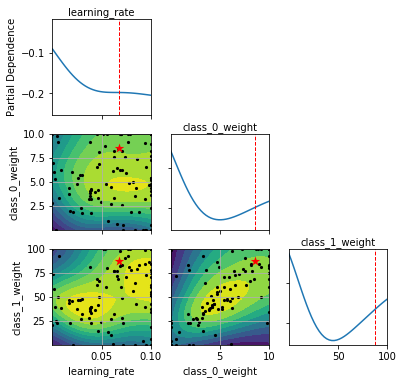

In [28]:
dim_names = [
    'learning_rate',
#     'past_history',
    'class_0_weight',
    'class_1_weight'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

### Take the winning hyperparameters and conduct a long training run. This is our 'Cassandra' model. It represents the upper bound - how well can the output be modeled from the input?

In [29]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.06761788678102645,
 'class_0_weight': 8.552362076028675,
 'class_1_weight': 87.16512996677713}

In [30]:
learning_rate = winning_hyperparams['learning_rate']
# past_history = winning_hyperparams['past_history']
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']

class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 350
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [31]:
x_train, y_train = data_functions.multivariate_data(
    training_data, 
    training_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data, 
    validation_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data, 
    test_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [32]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    100,
    batch_input_shape = input_shape,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [33]:
log_dir = f'./LSTM_logs/single_statefull_optimization_round1/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    callbacks = [tensorboard_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8
    #verbose = 0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/350
3250/3250 [==============================] - 3s 929us/sample - loss: 14.2281 - true_positives: 96.0000 - false_positives: 640.0000 - true_negatives: 2337.0000 - false_negatives: 177.0000 - auc: 0.6124 - matthews_correlation: 0.0796 - val_loss: 9.7225 - val_true_positives: 19.0000 - val_false_positives: 90.0000 - val_true_negatives: 2900.0000 - val_false_negatives: 241.0000 - val_auc: 0.7477 - val_matthews_correlation: 0.0526
Epoch 2/350
3250/3250 [==============================] - 0s 32us/sample - loss: 10.1104 - true_positives: 120.0000 - false_positives: 1060.0000 - true_negatives: 1917.0000 - false_negatives: 153.0000 - auc: 0.6487 - matthews_correlation: 0.0858 - val_loss: 9.0104 - val_true_positives: 41.0000 - val_false_positives: 193.0000 - val_true_negatives: 2797.0000 - val_false_negatives: 219.0000 - val_auc: 0.7764 - val_matthews_correlation: 0.0985
Epoch 3/350
3250/3

Epoch 38/350
3250/3250 [==============================] - 0s 30us/sample - loss: 5.0477 - true_positives: 259.0000 - false_positives: 662.0000 - true_negatives: 2315.0000 - false_negatives: 14.0000 - auc: 0.9169 - matthews_correlation: 0.4475 - val_loss: 10.3480 - val_true_positives: 177.0000 - val_false_positives: 893.0000 - val_true_negatives: 2097.0000 - val_false_negatives: 83.0000 - val_auc: 0.7467 - val_matthews_correlation: 0.2185
Epoch 39/350
3250/3250 [==============================] - 0s 31us/sample - loss: 4.9160 - true_positives: 262.0000 - false_positives: 664.0000 - true_negatives: 2313.0000 - false_negatives: 11.0000 - auc: 0.9238 - matthews_correlation: 0.4529 - val_loss: 11.0041 - val_true_positives: 157.0000 - val_false_positives: 872.0000 - val_true_negatives: 2118.0000 - val_false_negatives: 103.0000 - val_auc: 0.7406 - val_matthews_correlation: 0.1826
Epoch 40/350
3250/3250 [==============================] - 0s 32us/sample - loss: 4.7336 - true_positives: 259.0000 

Epoch 75/350
3250/3250 [==============================] - 0s 31us/sample - loss: 1.8070 - true_positives: 268.0000 - false_positives: 190.0000 - true_negatives: 2787.0000 - false_negatives: 5.0000 - auc: 0.9907 - matthews_correlation: 0.7312 - val_loss: 22.5782 - val_true_positives: 68.0000 - val_false_positives: 358.0000 - val_true_negatives: 2632.0000 - val_false_negatives: 192.0000 - val_auc: 0.7065 - val_matthews_correlation: 0.1193
Epoch 76/350
3250/3250 [==============================] - 0s 31us/sample - loss: 1.6405 - true_positives: 270.0000 - false_positives: 175.0000 - true_negatives: 2802.0000 - false_negatives: 3.0000 - auc: 0.9926 - matthews_correlation: 0.7483 - val_loss: 23.0238 - val_true_positives: 73.0000 - val_false_positives: 378.0000 - val_true_negatives: 2612.0000 - val_false_negatives: 187.0000 - val_auc: 0.7005 - val_matthews_correlation: 0.1275
Epoch 77/350
3250/3250 [==============================] - 0s 30us/sample - loss: 1.8259 - true_positives: 265.0000 - f

Epoch 94/350
3250/3250 [==============================] - 0s 32us/sample - loss: 1.3941 - true_positives: 272.0000 - false_positives: 175.0000 - true_negatives: 2802.0000 - false_negatives: 1.0000 - auc: 0.9938 - matthews_correlation: 0.7540 - val_loss: 29.1599 - val_true_positives: 58.0000 - val_false_positives: 290.0000 - val_true_negatives: 2700.0000 - val_false_negatives: 202.0000 - val_auc: 0.6744 - val_matthews_correlation: 0.1119
Epoch 95/350
3250/3250 [==============================] - 0s 32us/sample - loss: 1.4930 - true_positives: 266.0000 - false_positives: 106.0000 - true_negatives: 2871.0000 - false_negatives: 7.0000 - auc: 0.9936 - matthews_correlation: 0.8172 - val_loss: 27.0841 - val_true_positives: 74.0000 - val_false_positives: 367.0000 - val_true_negatives: 2623.0000 - val_false_negatives: 186.0000 - val_auc: 0.6810 - val_matthews_correlation: 0.1290
Epoch 96/350
3250/3250 [==============================] - 0s 31us/sample - loss: 1.5245 - true_positives: 270.0000 - f

Epoch 113/350
3250/3250 [==============================] - 0s 30us/sample - loss: 0.7673 - true_positives: 271.0000 - false_positives: 68.0000 - true_negatives: 2909.0000 - false_negatives: 2.0000 - auc: 0.9987 - matthews_correlation: 0.8800 - val_loss: 31.9843 - val_true_positives: 54.0000 - val_false_positives: 291.0000 - val_true_negatives: 2699.0000 - val_false_negatives: 206.0000 - val_auc: 0.6744 - val_matthews_correlation: 0.1009
Epoch 114/350
3250/3250 [==============================] - 0s 29us/sample - loss: 0.7786 - true_positives: 269.0000 - false_positives: 65.0000 - true_negatives: 2912.0000 - false_negatives: 4.0000 - auc: 0.9985 - matthews_correlation: 0.8807 - val_loss: 33.6326 - val_true_positives: 51.0000 - val_false_positives: 284.0000 - val_true_negatives: 2706.0000 - val_false_negatives: 209.0000 - val_auc: 0.6590 - val_matthews_correlation: 0.0947
Epoch 115/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.8755 - true_positives: 269.0000 - 

Epoch 132/350
3250/3250 [==============================] - 0s 30us/sample - loss: 1.1625 - true_positives: 271.0000 - false_positives: 141.0000 - true_negatives: 2836.0000 - false_negatives: 2.0000 - auc: 0.9968 - matthews_correlation: 0.7875 - val_loss: 28.8467 - val_true_positives: 78.0000 - val_false_positives: 352.0000 - val_true_negatives: 2638.0000 - val_false_negatives: 182.0000 - val_auc: 0.6848 - val_matthews_correlation: 0.1476
Epoch 133/350
3250/3250 [==============================] - 0s 30us/sample - loss: 0.9480 - true_positives: 267.0000 - false_positives: 69.0000 - true_negatives: 2908.0000 - false_negatives: 6.0000 - auc: 0.9975 - matthews_correlation: 0.8679 - val_loss: 29.9171 - val_true_positives: 60.0000 - val_false_positives: 323.0000 - val_true_negatives: 2667.0000 - val_false_negatives: 200.0000 - val_auc: 0.6814 - val_matthews_correlation: 0.1061
Epoch 134/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.9367 - true_positives: 271.0000 -

Epoch 151/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.6002 - true_positives: 271.0000 - false_positives: 60.0000 - true_negatives: 2917.0000 - false_negatives: 2.0000 - auc: 0.9990 - matthews_correlation: 0.8916 - val_loss: 36.6293 - val_true_positives: 56.0000 - val_false_positives: 310.0000 - val_true_negatives: 2680.0000 - val_false_negatives: 204.0000 - val_auc: 0.6459 - val_matthews_correlation: 0.0984
Epoch 152/350
3250/3250 [==============================] - 0s 33us/sample - loss: 0.6906 - true_positives: 268.0000 - false_positives: 52.0000 - true_negatives: 2925.0000 - false_negatives: 5.0000 - auc: 0.9986 - matthews_correlation: 0.8976 - val_loss: 38.8837 - val_true_positives: 50.0000 - val_false_positives: 287.0000 - val_true_negatives: 2703.0000 - val_false_negatives: 210.0000 - val_auc: 0.6312 - val_matthews_correlation: 0.0879
Epoch 153/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.7254 - true_positives: 269.0000 - 

Epoch 170/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.7264 - true_positives: 269.0000 - false_positives: 61.0000 - true_negatives: 2916.0000 - false_negatives: 4.0000 - auc: 0.9982 - matthews_correlation: 0.8853 - val_loss: 35.8041 - val_true_positives: 54.0000 - val_false_positives: 297.0000 - val_true_negatives: 2693.0000 - val_false_negatives: 206.0000 - val_auc: 0.6520 - val_matthews_correlation: 0.0941
Epoch 171/350
3250/3250 [==============================] - 0s 33us/sample - loss: 0.8128 - true_positives: 269.0000 - false_positives: 51.0000 - true_negatives: 2926.0000 - false_negatives: 4.0000 - auc: 0.9976 - matthews_correlation: 0.9016 - val_loss: 37.0933 - val_true_positives: 46.0000 - val_false_positives: 276.0000 - val_true_negatives: 2714.0000 - val_false_negatives: 214.0000 - val_auc: 0.6471 - val_matthews_correlation: 0.0788
Epoch 172/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.5757 - true_positives: 273.0000 - 

Epoch 189/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.4345 - true_positives: 272.0000 - false_positives: 39.0000 - true_negatives: 2938.0000 - false_negatives: 1.0000 - auc: 0.9991 - matthews_correlation: 0.9267 - val_loss: 39.5789 - val_true_positives: 51.0000 - val_false_positives: 257.0000 - val_true_negatives: 2733.0000 - val_false_negatives: 209.0000 - val_auc: 0.6560 - val_matthews_correlation: 0.1034
Epoch 190/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.3234 - true_positives: 272.0000 - false_positives: 25.0000 - true_negatives: 2952.0000 - false_negatives: 1.0000 - auc: 0.9999 - matthews_correlation: 0.9532 - val_loss: 39.5611 - val_true_positives: 52.0000 - val_false_positives: 264.0000 - val_true_negatives: 2726.0000 - val_false_negatives: 208.0000 - val_auc: 0.6477 - val_matthews_correlation: 0.1037
Epoch 191/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.6514 - true_positives: 271.0000 - 

Epoch 226/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.1989 - true_positives: 273.0000 - false_positives: 11.0000 - true_negatives: 2966.0000 - false_negatives: 0.0000e+00 - auc: 0.9999 - matthews_correlation: 0.9786 - val_loss: 48.3262 - val_true_positives: 39.0000 - val_false_positives: 231.0000 - val_true_negatives: 2759.0000 - val_false_negatives: 221.0000 - val_auc: 0.6121 - val_matthews_correlation: 0.0733
Epoch 227/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.1946 - true_positives: 272.0000 - false_positives: 11.0000 - true_negatives: 2966.0000 - false_negatives: 1.0000 - auc: 0.9999 - matthews_correlation: 0.9763 - val_loss: 48.1649 - val_true_positives: 43.0000 - val_false_positives: 252.0000 - val_true_negatives: 2738.0000 - val_false_negatives: 217.0000 - val_auc: 0.6138 - val_matthews_correlation: 0.0790
Epoch 228/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.2471 - true_positives: 272.000

Epoch 245/350
3250/3250 [==============================] - 0s 33us/sample - loss: 0.8173 - true_positives: 271.0000 - false_positives: 80.0000 - true_negatives: 2897.0000 - false_negatives: 2.0000 - auc: 0.9980 - matthews_correlation: 0.8617 - val_loss: 41.0820 - val_true_positives: 52.0000 - val_false_positives: 294.0000 - val_true_negatives: 2696.0000 - val_false_negatives: 208.0000 - val_auc: 0.6462 - val_matthews_correlation: 0.0905
Epoch 246/350
3250/3250 [==============================] - 0s 32us/sample - loss: 1.0155 - true_positives: 266.0000 - false_positives: 64.0000 - true_negatives: 2913.0000 - false_negatives: 7.0000 - auc: 0.9969 - matthews_correlation: 0.8746 - val_loss: 38.9411 - val_true_positives: 57.0000 - val_false_positives: 301.0000 - val_true_negatives: 2689.0000 - val_false_negatives: 203.0000 - val_auc: 0.6528 - val_matthews_correlation: 0.1034
Epoch 247/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.6938 - true_positives: 272.0000 - 

Epoch 264/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.7762 - true_positives: 271.0000 - false_positives: 52.0000 - true_negatives: 2925.0000 - false_negatives: 2.0000 - auc: 0.9971 - matthews_correlation: 0.9050 - val_loss: 40.7190 - val_true_positives: 44.0000 - val_false_positives: 277.0000 - val_true_negatives: 2713.0000 - val_false_negatives: 216.0000 - val_auc: 0.6525 - val_matthews_correlation: 0.0744
Epoch 265/350
3250/3250 [==============================] - 0s 30us/sample - loss: 0.4806 - true_positives: 272.0000 - false_positives: 34.0000 - true_negatives: 2943.0000 - false_negatives: 1.0000 - auc: 0.9994 - matthews_correlation: 0.9354 - val_loss: 42.2768 - val_true_positives: 40.0000 - val_false_positives: 237.0000 - val_true_negatives: 2753.0000 - val_false_negatives: 220.0000 - val_auc: 0.6393 - val_matthews_correlation: 0.0758
Epoch 266/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.4583 - true_positives: 271.0000 - 

Epoch 301/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.6898 - true_positives: 269.0000 - false_positives: 61.0000 - true_negatives: 2916.0000 - false_negatives: 4.0000 - auc: 0.9982 - matthews_correlation: 0.8875 - val_loss: 40.8268 - val_true_positives: 48.0000 - val_false_positives: 263.0000 - val_true_negatives: 2727.0000 - val_false_negatives: 212.0000 - val_auc: 0.6511 - val_matthews_correlation: 0.0909
Epoch 302/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.5582 - true_positives: 271.0000 - false_positives: 45.0000 - true_negatives: 2932.0000 - false_negatives: 2.0000 - auc: 0.9990 - matthews_correlation: 0.9147 - val_loss: 42.3659 - val_true_positives: 53.0000 - val_false_positives: 289.0000 - val_true_negatives: 2701.0000 - val_false_negatives: 207.0000 - val_auc: 0.6428 - val_matthews_correlation: 0.0975
Epoch 303/350
3250/3250 [==============================] - 0s 32us/sample - loss: 0.5089 - true_positives: 268.0000 - 

Epoch 320/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.2196 - true_positives: 273.0000 - false_positives: 24.0000 - true_negatives: 2953.0000 - false_negatives: 0.0000e+00 - auc: 0.9997 - matthews_correlation: 0.9538 - val_loss: 50.6901 - val_true_positives: 44.0000 - val_false_positives: 218.0000 - val_true_negatives: 2772.0000 - val_false_negatives: 216.0000 - val_auc: 0.6203 - val_matthews_correlation: 0.0968
Epoch 321/350
3250/3250 [==============================] - 0s 33us/sample - loss: 0.1659 - true_positives: 272.0000 - false_positives: 5.0000 - true_negatives: 2972.0000 - false_negatives: 1.0000 - auc: 1.0000 - matthews_correlation: 0.9880 - val_loss: 52.6362 - val_true_positives: 43.0000 - val_false_positives: 200.0000 - val_true_negatives: 2790.0000 - val_false_negatives: 217.0000 - val_auc: 0.6006 - val_matthews_correlation: 0.1023
Epoch 322/350
3250/3250 [==============================] - 0s 31us/sample - loss: 0.1229 - true_positives: 273.0000

Total observations: 3287


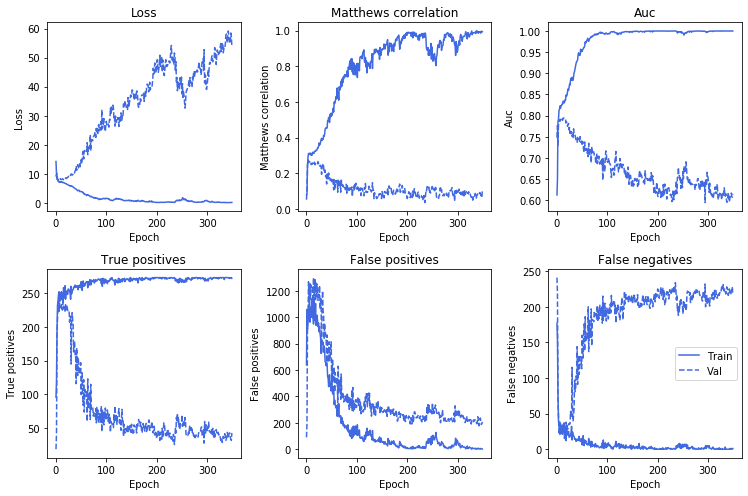

In [34]:
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../../figures/single_LSTM_learning_curves_CA_only.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [35]:
train_predictions = model.predict(x_train)
validation_predictions = model.predict(x_validation)
test_predictions = model.predict(x_testing)

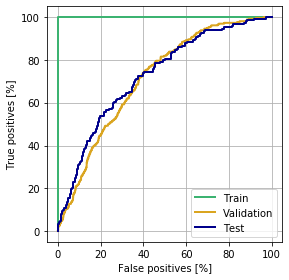

In [36]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='mediumseagreen')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

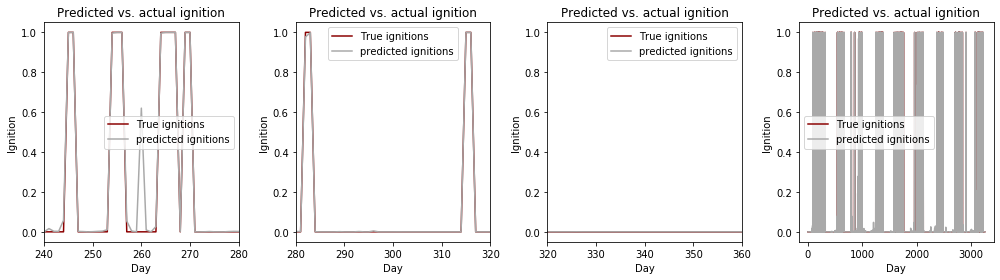

In [37]:
filename = '../../figures/single_statefull_LSTM_training_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

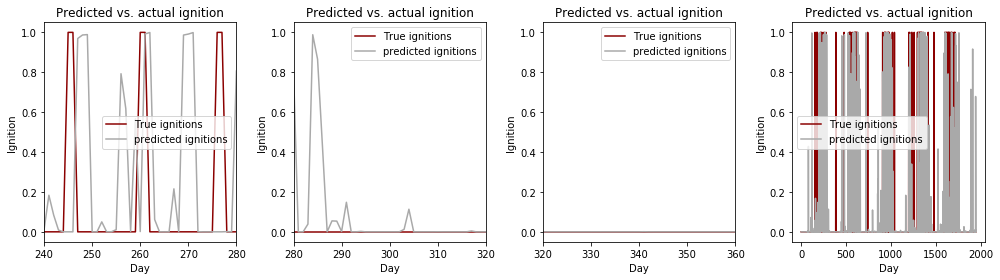

In [38]:
filename = '../../figures/single_statefull_LSTM_testing_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)

loss :  0.010153214633464813
true_positives :  273.0
false_positives :  8.0
true_negatives :  2969.0
false_negatives :  0.0
auc :  0.99981606
matthews_correlation :  0.9817381
No fire (True Negatives):  2968
False alarms (False Positives):  9
Fires missed (False Negatives):  0
Fires detected (True Positives):  273
Total fires:  273


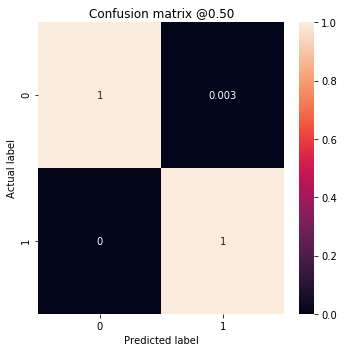

In [39]:
results = model.evaluate(
    x_train,
    y_train, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_train, train_predictions)

### Sucess - we have achieved 100% accuracy on the training data. This means that the code is working and the problem is tractable. The challenge now is the regularize the model so that it will generalize.

loss :  0.7854002714157104
true_positives :  25.0
false_positives :  102.0
true_negatives :  1699.0
false_negatives :  124.0
auc :  0.6554432
matthews_correlation :  0.117906965
No fire (True Negatives):  1701
False alarms (False Positives):  100
Fires missed (False Negatives):  126
Fires detected (True Positives):  23
Total fires:  149


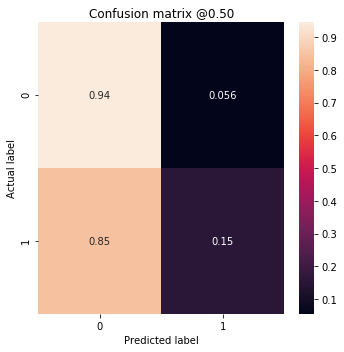

In [40]:
results = model.evaluate(
    x_testing,
    y_testing, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_testing, test_predictions)

### To improve generalizability we will run a second Gaussian process minimization.
1. Number of LSTM units will be added as a tunable parameter
2. Variational dropout will be added to the LSTM units as a tunable parameter
3. Gaussian optimization and early stopping will use Matthews correlation on the validation set rather than the training set

In [41]:
future_target = 1
step = 1
past_history = 5
lstm_units = 1

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

EPOCHS = 50

path_best_model = '../../trained_models/best_skopt_single_statefull_LTSM_CA_only.keras'
best_val_matthews_correlation = -1.0

metrics = [
    keras.metrics.TruePositives(name = 'true_positives'),
    keras.metrics.FalsePositives(name = 'false_positives'),
    keras.metrics.TrueNegatives(name = 'true_negatives'),
    keras.metrics.FalseNegatives(name = 'false_negatives'), 
    keras.metrics.AUC(name = 'auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low = 0.0001,
    high = 0.1, 
    name = 'learning_rate'
)

# dim_past_history = Integer(
#     low = 1,
#     high = 5, 
#     name = 'past_history'
# )

dim_class_0_weight = Real(
    low = 0.001, 
    high = 20,
    name = 'class_0_weight'
)

dim_class_1_weight = Real(
    low = 0.01, 
    high = 100,
    name = 'class_1_weight'
)

# dim_lstm_units = Integer(
#     low=1, 
#     high=5,
#     name='lstm_units'
# )

dim_variational_dropout = Real(
    low=0.01, 
    high=0.5,
    name='variational_dropout'
)

dim_recurrent_dropout = Real(
    low=0.01, 
    high=0.5,
    name='recurrent_dropout'
)

default_parameters = [learning_rate, class_0_weight, class_1_weight, 0.1, 0.1]
#default_parameters = [50, 0.1]

dimensions = [
    dim_learning_rate,
#     dim_past_history, 
    dim_class_0_weight, 
    dim_class_1_weight,
#     dim_lstm_units,
    dim_variational_dropout,
    dim_recurrent_dropout
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_matthews_correlation', 
    #verbose = 0,
    patience = 5,
    mode = 'max',
    restore_best_weights = True
)

run_num = 1

In [42]:
def make_model(
        input_shape,
        learning_rate,
        lstm_units,
        variational_dropout,
        recurrent_dropout
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape = input_shape,
        dropout = variational_dropout,
        recurrent_dropout = recurrent_dropout,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
#     past_history,
    learning_rate,
    class_0_weight,
    class_1_weight,
#     lstm_units,
    variational_dropout,
    recurrent_dropout
):

    # Print the hyper-parameters.
#     print('past history:', past_history)
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('class 0 weight: {0:.1e}'.format(class_0_weight))
    print('class 1 weight: {0:.1e}'.format(class_1_weight))
#     print('lstm units:', lstm_units)
    print('variational droput: {0:.1e}'.format(variational_dropout))
    print('recurrent dropout: {0:.1e}'.format(recurrent_dropout))
    print()
    
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    # create data stream
    x_train, y_train = data_functions.multivariate_data(
        training_data, 
        training_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data, 
        validation_labels, 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape = input_shape,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        variational_dropout = variational_dropout,
        recurrent_dropout = recurrent_dropout
    )
    
    model.summary()
    print()
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8
        #verbose=0
    )

    val_matthews_correlation = history.history['val_matthews_correlation'][-1]
    
    print()
    print()
    print(f"Run {run_num} final validation matthews correlation: {val_matthews_correlation}")
    print()
    
    run_num += 1

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_val_matthews_correlation

    # If the classification accuracy of the saved model is improved ...
    if val_matthews_correlation > best_val_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_val_matthews_correlation = val_matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -val_matthews_correlation

In [43]:
%%time

search_result = gp_minimize(
    func = fitness,
    dimensions = dimensions,
    acq_func = 'EI', # Expected Improvement.
    n_calls = 200,
    x0 = default_parameters
)

learning rate: 6.8e-02
class 0 weight: 8.6e+00
class 1 weight: 8.7e+01
variational droput: 1.0e-01
recurrent dropout: 1.0e-01

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (650, 1)                  88        
_________________________________________________________________
dense_1 (Dense)              (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.4925 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5625 - matthews_correlation: 0.0000e+00 - val_loss: 13.5702 - val_true_positives: 0.

Epoch 3/50
3250/3250 [==============================] - 0s 52us/sample - loss: 14.7233 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6230 - matthews_correlation: 0.0000e+00 - val_loss: 12.7892 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5798 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 48us/sample - loss: 12.7521 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6558 - matthews_correlation: 0.0000e+00 - val_loss: 11.3381 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6261 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
3250/3250 [==============================] - 0s 50us/sample - loss: 11.

3250/3250 [==============================] - 0s 48us/sample - loss: 7.9718 - true_positives: 260.0000 - false_positives: 1316.0000 - true_negatives: 1661.0000 - false_negatives: 13.0000 - auc: 0.8125 - matthews_correlation: 0.2824 - val_loss: 8.2845 - val_true_positives: 244.0000 - val_false_positives: 1437.0000 - val_true_negatives: 1553.0000 - val_false_negatives: 16.0000 - val_auc: 0.7839 - val_matthews_correlation: 0.2449
Epoch 7/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.8298 - true_positives: 256.0000 - false_positives: 1210.0000 - true_negatives: 1767.0000 - false_negatives: 17.0000 - auc: 0.8149 - matthews_correlation: 0.2961 - val_loss: 8.0438 - val_true_positives: 243.0000 - val_false_positives: 1328.0000 - val_true_negatives: 1662.0000 - val_false_negatives: 17.0000 - val_auc: 0.7854 - val_matthews_correlation: 0.2630
Epoch 8/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.7413 - true_positives: 252.0000 - false_positive

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 18.0527 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5947 - matthews_correlation: 0.0000e+00 - val_loss: 15.5298 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6813 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 46us/sample - loss: 15.1059 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7030 - matthews_correlation: 0.0000e+00 - val_loss: 12.6009 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7213 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [=============

3250/3250 [==============================] - 0s 50us/sample - loss: 7.6495 - true_positives: 240.0000 - false_positives: 980.0000 - true_negatives: 1997.0000 - false_negatives: 33.0000 - auc: 0.8064 - matthews_correlation: 0.3148 - val_loss: 7.9746 - val_true_positives: 232.0000 - val_false_positives: 1093.0000 - val_true_negatives: 1897.0000 - val_false_negatives: 28.0000 - val_auc: 0.7833 - val_matthews_correlation: 0.2872
Epoch 9/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.5612 - true_positives: 243.0000 - false_positives: 1029.0000 - true_negatives: 1948.0000 - false_negatives: 30.0000 - auc: 0.8078 - matthews_correlation: 0.3071 - val_loss: 7.9507 - val_true_positives: 233.0000 - val_false_positives: 1144.0000 - val_true_negatives: 1846.0000 - val_false_negatives: 27.0000 - val_auc: 0.7852 - val_matthews_correlation: 0.2780
Epoch 10/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.5116 - true_positives: 249.0000 - false_positive

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 15.0763 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5963 - matthews_correlation: 0.0000e+00 - val_loss: 10.7764 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6857 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 51us/sample - loss: 9.9140 - true_positives: 45.0000 - false_positives: 185.0000 - true_negatives: 2792.0000 - false_negatives: 228.0000 - auc: 0.7056 - matthews_correlation: 0.0789 - val_loss: 8.9259 - val_true_positives: 241.0000 - val_false_positives: 1427.0000 - val_true_negatives: 1563.0000 - val_false_negatives: 19.0000 - val_auc: 0.7580 - val_matthews_correlation: 0.2406
Epoch 3/50
3250/3250 [=======

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.6772 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5718 - matthews_correlation: 0.0000e+00 - val_loss: 14.5915 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6857 - va

Epoch 18/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.3362 - true_positives: 248.0000 - false_positives: 1022.0000 - true_negatives: 1955.0000 - false_negatives: 25.0000 - auc: 0.8160 - matthews_correlation: 0.3210 - val_loss: 7.9543 - val_true_positives: 233.0000 - val_false_positives: 1126.0000 - val_true_negatives: 1864.0000 - val_false_negatives: 27.0000 - val_auc: 0.7832 - val_matthews_correlation: 0.2816
Epoch 19/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.3242 - true_positives: 242.0000 - false_positives: 989.0000 - true_negatives: 1988.0000 - false_negatives: 31.0000 - auc: 0.8185 - matthews_correlation: 0.3170 - val_loss: 7.9624 - val_true_positives: 232.0000 - val_false_positives: 1113.0000 - val_true_negatives: 1877.0000 - val_false_negatives: 28.0000 - val_auc: 0.7848 - val_matthews_correlation: 0.2826


Run 11 final validation matthews correlation: 0.28256621956825256

learning rate: 5.9e-02
class 0 weight: 3.1e+00
c

3250/3250 [==============================] - 0s 51us/sample - loss: 7.6093 - true_positives: 248.0000 - false_positives: 1080.0000 - true_negatives: 1897.0000 - false_negatives: 25.0000 - auc: 0.8044 - matthews_correlation: 0.3072 - val_loss: 7.9454 - val_true_positives: 237.0000 - val_false_positives: 1207.0000 - val_true_negatives: 1783.0000 - val_false_negatives: 23.0000 - val_auc: 0.7955 - val_matthews_correlation: 0.2741
Epoch 13/50
3250/3250 [==============================] - 0s 47us/sample - loss: 7.4983 - true_positives: 250.0000 - false_positives: 1040.0000 - true_negatives: 1937.0000 - false_negatives: 23.0000 - auc: 0.8068 - matthews_correlation: 0.3206 - val_loss: 7.8689 - val_true_positives: 236.0000 - val_false_positives: 1139.0000 - val_true_negatives: 1851.0000 - val_false_negatives: 24.0000 - val_auc: 0.7906 - val_matthews_correlation: 0.2858
Epoch 14/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.4505 - true_positives: 244.0000 - false_positi

Epoch 2/50
3250/3250 [==============================] - 0s 50us/sample - loss: 13.8526 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6094 - matthews_correlation: 0.0000e+00 - val_loss: 10.9294 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7118 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 54us/sample - loss: 10.1182 - true_positives: 31.0000 - false_positives: 100.0000 - true_negatives: 2877.0000 - false_negatives: 242.0000 - auc: 0.7111 - matthews_correlation: 0.0651 - val_loss: 9.0081 - val_true_positives: 240.0000 - val_false_positives: 1429.0000 - val_true_negatives: 1561.0000 - val_false_negatives: 20.0000 - val_auc: 0.7712 - val_matthews_correlation: 0.2390
Epoch 4/50
3250/3250 [==============================] - 0s 48us/sample - loss: 8.8670 - true_positiv

3250/3250 [==============================] - 3s 1ms/sample - loss: 18.9337 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.3575 - matthews_correlation: 0.0000e+00 - val_loss: 16.8960 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.4508 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 47us/sample - loss: 16.2205 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5262 - matthews_correlation: 0.0000e+00 - val_loss: 13.8769 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6632 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 50us/sample - loss: 13.3067 - true_

Epoch 6/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.9700 - true_positives: 248.0000 - false_positives: 1135.0000 - true_negatives: 1842.0000 - false_negatives: 25.0000 - auc: 0.7917 - matthews_correlation: 0.2951 - val_loss: 7.9957 - val_true_positives: 235.0000 - val_false_positives: 1119.0000 - val_true_negatives: 1871.0000 - val_false_negatives: 25.0000 - val_auc: 0.7896 - val_matthews_correlation: 0.2884
Epoch 7/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.8402 - true_positives: 239.0000 - false_positives: 1006.0000 - true_negatives: 1971.0000 - false_negatives: 34.0000 - auc: 0.7967 - matthews_correlation: 0.3076 - val_loss: 8.0811 - val_true_positives: 234.0000 - val_false_positives: 1114.0000 - val_true_negatives: 1876.0000 - val_false_negatives: 26.0000 - val_auc: 0.7860 - val_matthews_correlation: 0.2874
Epoch 8/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7651 - true_positives: 240.0000 - fal

3250/3250 [==============================] - 0s 47us/sample - loss: 8.5739 - true_positives: 265.0000 - false_positives: 1540.0000 - true_negatives: 1437.0000 - false_negatives: 8.0000 - auc: 0.7711 - matthews_correlation: 0.2525 - val_loss: 8.8022 - val_true_positives: 246.0000 - val_false_positives: 1602.0000 - val_true_negatives: 1388.0000 - val_false_negatives: 14.0000 - val_auc: 0.7725 - val_matthews_correlation: 0.2213
Epoch 5/50
3250/3250 [==============================] - 0s 48us/sample - loss: 8.2820 - true_positives: 256.0000 - false_positives: 1321.0000 - true_negatives: 1656.0000 - false_negatives: 17.0000 - auc: 0.7970 - matthews_correlation: 0.2743 - val_loss: 8.4110 - val_true_positives: 242.0000 - val_false_positives: 1401.0000 - val_true_negatives: 1589.0000 - val_false_negatives: 18.0000 - val_auc: 0.7772 - val_matthews_correlation: 0.2476
Epoch 6/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.0567 - true_positives: 253.0000 - false_positives

Epoch 23/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.3375 - true_positives: 246.0000 - false_positives: 1042.0000 - true_negatives: 1935.0000 - false_negatives: 27.0000 - auc: 0.8172 - matthews_correlation: 0.3128 - val_loss: 7.9583 - val_true_positives: 233.0000 - val_false_positives: 1106.0000 - val_true_negatives: 1884.0000 - val_false_negatives: 27.0000 - val_auc: 0.7981 - val_matthews_correlation: 0.2874


Run 20 final validation matthews correlation: 0.2873827815055847

learning rate: 5.5e-02
class 0 weight: 9.6e+00
class 1 weight: 1.1e+01
variational droput: 3.1e-02
recurrent dropout: 6.1e-02

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params:

3250/3250 [==============================] - 0s 53us/sample - loss: 8.1393 - true_positives: 250.0000 - false_positives: 1148.0000 - true_negatives: 1829.0000 - false_negatives: 23.0000 - auc: 0.7889 - matthews_correlation: 0.2972 - val_loss: 8.0928 - val_true_positives: 238.0000 - val_false_positives: 1187.0000 - val_true_negatives: 1803.0000 - val_false_negatives: 22.0000 - val_auc: 0.7806 - val_matthews_correlation: 0.2803
Epoch 8/50
3250/3250 [==============================] - 0s 46us/sample - loss: 8.0001 - true_positives: 245.0000 - false_positives: 1045.0000 - true_negatives: 1932.0000 - false_negatives: 28.0000 - auc: 0.7851 - matthews_correlation: 0.3101 - val_loss: 8.0019 - val_true_positives: 230.0000 - val_false_positives: 1118.0000 - val_true_negatives: 1872.0000 - val_false_negatives: 30.0000 - val_auc: 0.7779 - val_matthews_correlation: 0.2779
Epoch 9/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.7189 - true_positives: 242.0000 - false_positive

3250/3250 [==============================] - 0s 48us/sample - loss: 8.3806 - true_positives: 257.0000 - false_positives: 1466.0000 - true_negatives: 1511.0000 - false_negatives: 16.0000 - auc: 0.7796 - matthews_correlation: 0.2482 - val_loss: 8.6276 - val_true_positives: 247.0000 - val_false_positives: 1562.0000 - val_true_negatives: 1428.0000 - val_false_negatives: 13.0000 - val_auc: 0.7876 - val_matthews_correlation: 0.2299
Epoch 4/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.0943 - true_positives: 251.0000 - false_positives: 1248.0000 - true_negatives: 1729.0000 - false_negatives: 22.0000 - auc: 0.8044 - matthews_correlation: 0.2768 - val_loss: 8.2330 - val_true_positives: 242.0000 - val_false_positives: 1332.0000 - val_true_negatives: 1658.0000 - val_false_negatives: 18.0000 - val_auc: 0.7907 - val_matthews_correlation: 0.2598
Epoch 5/50
3250/3250 [==============================] - 0s 49us/sample - loss: 8.1650 - true_positives: 237.0000 - false_positive

3250/3250 [==============================] - 0s 49us/sample - loss: 16.7167 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6342 - matthews_correlation: 0.0000e+00 - val_loss: 15.4583 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6688 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
3250/3250 [==============================] - 0s 50us/sample - loss: 15.9575 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6871 - matthews_correlation: 0.0000e+00 - val_loss: 14.8449 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6795 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
3250/3250 [==============================] - 0s 52us/sample - loss: 15.2935 - true

3250/3250 [==============================] - 0s 52us/sample - loss: 7.9607 - true_positives: 235.0000 - false_positives: 1032.0000 - true_negatives: 1945.0000 - false_negatives: 38.0000 - auc: 0.7961 - matthews_correlation: 0.2921 - val_loss: 7.7331 - val_true_positives: 238.0000 - val_false_positives: 1183.0000 - val_true_negatives: 1807.0000 - val_false_negatives: 22.0000 - val_auc: 0.8006 - val_matthews_correlation: 0.2813
Epoch 13/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.0730 - true_positives: 236.0000 - false_positives: 1071.0000 - true_negatives: 1906.0000 - false_negatives: 37.0000 - auc: 0.7872 - matthews_correlation: 0.2856 - val_loss: 7.7482 - val_true_positives: 238.0000 - val_false_positives: 1200.0000 - val_true_negatives: 1790.0000 - val_false_negatives: 22.0000 - val_auc: 0.8013 - val_matthews_correlation: 0.2777
Epoch 14/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.6552 - true_positives: 250.0000 - false_positi

3250/3250 [==============================] - 0s 47us/sample - loss: 15.5814 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5779 - matthews_correlation: 0.0000e+00 - val_loss: 12.9311 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6750 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 49us/sample - loss: 12.2406 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6799 - matthews_correlation: 0.0000e+00 - val_loss: 10.7062 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7082 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 50us/sample - loss: 10.4240 - true

3250/3250 [==============================] - 0s 50us/sample - loss: 7.9156 - true_positives: 238.0000 - false_positives: 1007.0000 - true_negatives: 1970.0000 - false_negatives: 35.0000 - auc: 0.7987 - matthews_correlation: 0.3045 - val_loss: 8.1341 - val_true_positives: 236.0000 - val_false_positives: 1169.0000 - val_true_negatives: 1821.0000 - val_false_negatives: 24.0000 - val_auc: 0.7771 - val_matthews_correlation: 0.2804
Epoch 12/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.8292 - true_positives: 242.0000 - false_positives: 1046.0000 - true_negatives: 1931.0000 - false_negatives: 31.0000 - auc: 0.8007 - matthews_correlation: 0.3028 - val_loss: 8.1695 - val_true_positives: 236.0000 - val_false_positives: 1206.0000 - val_true_negatives: 1784.0000 - val_false_negatives: 24.0000 - val_auc: 0.7747 - val_matthews_correlation: 0.2730
Epoch 13/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.8710 - true_positives: 245.0000 - false_positi

3250/3250 [==============================] - 0s 51us/sample - loss: 7.5405 - true_positives: 244.0000 - false_positives: 1060.0000 - true_negatives: 1917.0000 - false_negatives: 29.0000 - auc: 0.8098 - matthews_correlation: 0.3049 - val_loss: 8.0698 - val_true_positives: 226.0000 - val_false_positives: 1152.0000 - val_true_negatives: 1838.0000 - val_false_negatives: 34.0000 - val_auc: 0.7890 - val_matthews_correlation: 0.2609
Epoch 12/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.5069 - true_positives: 250.0000 - false_positives: 1061.0000 - true_negatives: 1916.0000 - false_negatives: 23.0000 - auc: 0.8125 - matthews_correlation: 0.3156 - val_loss: 8.0378 - val_true_positives: 233.0000 - val_false_positives: 1175.0000 - val_true_negatives: 1815.0000 - val_false_negatives: 27.0000 - val_auc: 0.7924 - val_matthews_correlation: 0.2720
Epoch 13/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.4035 - true_positives: 251.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 8.3070 - true_positives: 256.0000 - false_positives: 1347.0000 - true_negatives: 1630.0000 - false_negatives: 17.0000 - auc: 0.8039 - matthews_correlation: 0.2694 - val_loss: 8.5334 - val_true_positives: 242.0000 - val_false_positives: 1356.0000 - val_true_negatives: 1634.0000 - val_false_negatives: 18.0000 - val_auc: 0.7827 - val_matthews_correlation: 0.2557
Epoch 6/50
3250/3250 [==============================] - 0s 49us/sample - loss: 8.0391 - true_positives: 249.0000 - false_positives: 1179.0000 - true_negatives: 1798.0000 - false_negatives: 24.0000 - auc: 0.8040 - matthews_correlation: 0.2872 - val_loss: 8.1499 - val_true_positives: 233.0000 - val_false_positives: 1195.0000 - val_true_negatives: 1795.0000 - val_false_negatives: 27.0000 - val_auc: 0.7867 - val_matthews_correlation: 0.2684
Epoch 7/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.8383 - true_positives: 242.0000 - false_positive

Epoch 24/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.2734 - true_positives: 243.0000 - false_positives: 1042.0000 - true_negatives: 1935.0000 - false_negatives: 30.0000 - auc: 0.8296 - matthews_correlation: 0.3048 - val_loss: 8.0476 - val_true_positives: 234.0000 - val_false_positives: 1126.0000 - val_true_negatives: 1864.0000 - val_false_negatives: 26.0000 - val_auc: 0.7951 - val_matthews_correlation: 0.2849
Epoch 25/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.5055 - true_positives: 242.0000 - false_positives: 1037.0000 - true_negatives: 1940.0000 - false_negatives: 31.0000 - auc: 0.8143 - matthews_correlation: 0.3032 - val_loss: 8.0622 - val_true_positives: 235.0000 - val_false_positives: 1155.0000 - val_true_negatives: 1835.0000 - val_false_negatives: 25.0000 - val_auc: 0.7973 - val_matthews_correlation: 0.2809
Epoch 26/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.3765 - true_positives: 247.0000 - 

3250/3250 [==============================] - 0s 52us/sample - loss: 8.3167 - true_positives: 260.0000 - false_positives: 1327.0000 - true_negatives: 1650.0000 - false_negatives: 13.0000 - auc: 0.8029 - matthews_correlation: 0.2813 - val_loss: 8.5356 - val_true_positives: 242.0000 - val_false_positives: 1377.0000 - val_true_negatives: 1613.0000 - val_false_negatives: 18.0000 - val_auc: 0.7724 - val_matthews_correlation: 0.2519
Epoch 6/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.0011 - true_positives: 253.0000 - false_positives: 1187.0000 - true_negatives: 1790.0000 - false_negatives: 20.0000 - auc: 0.8017 - matthews_correlation: 0.2942 - val_loss: 8.1333 - val_true_positives: 238.0000 - val_false_positives: 1216.0000 - val_true_negatives: 1774.0000 - val_false_negatives: 22.0000 - val_auc: 0.7781 - val_matthews_correlation: 0.2740
Epoch 7/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.6931 - true_positives: 248.0000 - false_positive

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.0053 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5692 - matthews_correlation: 0.0000e+00 - val_loss: 13.0943 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6747 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 52us/sample - loss: 11.5241 - true_positives: 0.0000e+00 - false_positives: 1.0000 - true_negatives: 2976.0000 - false_negatives: 273.0000 - auc: 0.6956 - matthews_correlation: -0.0023 - val_loss: 9.4105 - val_true_positives: 5.0000 - val_false_positives: 18.0000 - val_true_negatives: 2972.0000 - val_false_negatives: 255.0000 - val_auc: 0.7266 - val_matthews_correlation: 0.0286
Epoch 3/50
3250/3250 [=======

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 6s 2ms/sample - loss: 17.8082 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5109 - matthews_correlation: 0.0000e+00 - val_loss: 15.4205 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 47us/sample - loss: 15.1425 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4899 - matthews_correlation: 0.0000e+00 - val_loss: 13.1245 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5524 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [=============

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 16.1326 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6023 - matthews_correlation: 0.0000e+00 - val_loss: 11.5078 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7502 - va



Run 42 final validation matthews correlation: 0.2759346663951874

learning rate: 1.0e-01
class 0 weight: 2.0e+01
class 1 weight: 1.0e+02
variational droput: 5.0e-01
recurrent dropout: 5.0e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 17.8269 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5110 - matthews_co

Epoch 3/50
3250/3250 [==============================] - 0s 49us/sample - loss: 8.4120 - true_positives: 255.0000 - false_positives: 1397.0000 - true_negatives: 1580.0000 - false_negatives: 18.0000 - auc: 0.7711 - matthews_correlation: 0.2568 - val_loss: 8.8351 - val_true_positives: 248.0000 - val_false_positives: 1679.0000 - val_true_negatives: 1311.0000 - val_false_negatives: 12.0000 - val_auc: 0.7669 - val_matthews_correlation: 0.2138
Epoch 4/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.2528 - true_positives: 263.0000 - false_positives: 1368.0000 - true_negatives: 1609.0000 - false_negatives: 10.0000 - auc: 0.7832 - matthews_correlation: 0.2786 - val_loss: 8.7392 - val_true_positives: 244.0000 - val_false_positives: 1470.0000 - val_true_negatives: 1520.0000 - val_false_negatives: 16.0000 - val_auc: 0.7681 - val_matthews_correlation: 0.2395
Epoch 5/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.9821 - true_positives: 255.0000 - fal

Epoch 20/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.0679 - true_positives: 254.0000 - false_positives: 1088.0000 - true_negatives: 1889.0000 - false_negatives: 19.0000 - auc: 0.8189 - matthews_correlation: 0.3177 - val_loss: 8.1561 - val_true_positives: 241.0000 - val_false_positives: 1281.0000 - val_true_negatives: 1709.0000 - val_false_negatives: 19.0000 - val_auc: 0.7961 - val_matthews_correlation: 0.2683
Epoch 21/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.0582 - true_positives: 251.0000 - false_positives: 1072.0000 - true_negatives: 1905.0000 - false_negatives: 22.0000 - auc: 0.8253 - matthews_correlation: 0.3148 - val_loss: 8.0955 - val_true_positives: 237.0000 - val_false_positives: 1224.0000 - val_true_negatives: 1766.0000 - val_false_negatives: 23.0000 - val_auc: 0.7956 - val_matthews_correlation: 0.2712
Epoch 22/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.0275 - true_positives: 246.0000 - 

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.1819 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6573 - matthews_correlation: 0.0000e+00 - val_loss: 13.6906 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7441 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 45us/sample - loss: 13.1054 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7143 - matthews_correlation: 0.0000e+00 - val_loss: 10.8789 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7311 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 18.1855 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4866 - matthews_correlation: 0.0000e+00 - val_loss: 15.8602 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5748 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 47us/sample - loss: 15.4823 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5954 - matthews_correlation: 0.0000e+00 - val_loss: 13.2422 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6204 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [=============

3250/3250 [==============================] - 0s 52us/sample - loss: 7.9983 - true_positives: 238.0000 - false_positives: 1052.0000 - true_negatives: 1925.0000 - false_negatives: 35.0000 - auc: 0.7960 - matthews_correlation: 0.2937 - val_loss: 7.9593 - val_true_positives: 232.0000 - val_false_positives: 1153.0000 - val_true_negatives: 1837.0000 - val_false_negatives: 28.0000 - val_auc: 0.7936 - val_matthews_correlation: 0.2753
Epoch 17/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.7375 - true_positives: 241.0000 - false_positives: 1037.0000 - true_negatives: 1940.0000 - false_negatives: 32.0000 - auc: 0.8049 - matthews_correlation: 0.3040 - val_loss: 7.9637 - val_true_positives: 232.0000 - val_false_positives: 1158.0000 - val_true_negatives: 1832.0000 - val_false_negatives: 28.0000 - val_auc: 0.7931 - val_matthews_correlation: 0.2743
Epoch 18/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.7017 - true_positives: 243.0000 - false_positi



Run 50 final validation matthews correlation: 0.27468937635421753

learning rate: 8.0e-02
class 0 weight: 1.0e-03
class 1 weight: 1.0e+02
variational droput: 5.0e-01
recurrent dropout: 5.0e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 17.8514 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5668 - matthews_c

3250/3250 [==============================] - 0s 54us/sample - loss: 7.4249 - true_positives: 245.0000 - false_positives: 1019.0000 - true_negatives: 1958.0000 - false_negatives: 28.0000 - auc: 0.8116 - matthews_correlation: 0.3156 - val_loss: 7.9171 - val_true_positives: 235.0000 - val_false_positives: 1146.0000 - val_true_negatives: 1844.0000 - val_false_negatives: 25.0000 - val_auc: 0.7922 - val_matthews_correlation: 0.2825
Epoch 13/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.3573 - true_positives: 248.0000 - false_positives: 1031.0000 - true_negatives: 1946.0000 - false_negatives: 25.0000 - auc: 0.8121 - matthews_correlation: 0.3183 - val_loss: 7.8861 - val_true_positives: 235.0000 - val_false_positives: 1120.0000 - val_true_negatives: 1870.0000 - val_false_negatives: 25.0000 - val_auc: 0.7890 - val_matthews_correlation: 0.2881
Epoch 14/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.3163 - true_positives: 247.0000 - false_positi

3250/3250 [==============================] - 0s 47us/sample - loss: 8.1475 - true_positives: 256.0000 - false_positives: 1298.0000 - true_negatives: 1679.0000 - false_negatives: 17.0000 - auc: 0.7980 - matthews_correlation: 0.2774 - val_loss: 8.2939 - val_true_positives: 242.0000 - val_false_positives: 1348.0000 - val_true_negatives: 1642.0000 - val_false_negatives: 18.0000 - val_auc: 0.7765 - val_matthews_correlation: 0.2569
Epoch 7/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.7644 - true_positives: 253.0000 - false_positives: 1184.0000 - true_negatives: 1793.0000 - false_negatives: 20.0000 - auc: 0.8035 - matthews_correlation: 0.2953 - val_loss: 7.9755 - val_true_positives: 241.0000 - val_false_positives: 1220.0000 - val_true_negatives: 1770.0000 - val_false_negatives: 19.0000 - val_auc: 0.7804 - val_matthews_correlation: 0.2797
Epoch 8/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.7719 - true_positives: 247.0000 - false_positive

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 6s 2ms/sample - loss: 14.9513 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6984 - matthews_correlation: 0.0000e+00 - val_loss: 11.3589 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7130 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 52us/sample - loss: 10.3731 - true_positives: 2.0000 - false_positives: 22.0000 - true_negatives: 2955.0000 - false_negatives: 271.0000 - auc: 0.7156 - matthews_correlation: 2.5684e-04 - val_loss: 8.9477 - val_true_positives: 160.0000 - val_false_positives: 754.0000 - val_true_negatives: 2236.0000 - val_false_negatives: 100.0000 - val_auc: 0.7650 - val_matthews_correlation: 0.2106
Epoch 3/50
3250/3250 [====

Epoch 3/50
3250/3250 [==============================] - 0s 48us/sample - loss: 8.5007 - true_positives: 215.0000 - false_positives: 1072.0000 - true_negatives: 1905.0000 - false_negatives: 58.0000 - auc: 0.7770 - matthews_correlation: 0.2505 - val_loss: 8.6648 - val_true_positives: 245.0000 - val_false_positives: 1679.0000 - val_true_negatives: 1311.0000 - val_false_negatives: 15.0000 - val_auc: 0.7833 - val_matthews_correlation: 0.2065
Epoch 4/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.1365 - true_positives: 259.0000 - false_positives: 1462.0000 - true_negatives: 1515.0000 - false_negatives: 14.0000 - auc: 0.7969 - matthews_correlation: 0.2538 - val_loss: 8.6337 - val_true_positives: 244.0000 - val_false_positives: 1586.0000 - val_true_negatives: 1404.0000 - val_false_negatives: 16.0000 - val_auc: 0.7852 - val_matthews_correlation: 0.2195
Epoch 5/50
3250/3250 [==============================] - 0s 54us/sample - loss: 8.0235 - true_positives: 258.0000 - fal



Run 57 final validation matthews correlation: 0.2699199318885803

learning rate: 7.0e-02
class 0 weight: 1.0e+00
class 1 weight: 5.1e+00
variational droput: 1.6e-01
recurrent dropout: 3.7e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.7500 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5860 - matthews_co

learning rate: 1.0e-01
class 0 weight: 2.1e+00
class 1 weight: 3.0e+01
variational droput: 5.0e-01
recurrent dropout: 4.8e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.0221 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5736 - matthews_correlation: 0.0000e+00 - val_loss: 12.8393 - val_true_positives: 0.00

Epoch 3/50
3250/3250 [==============================] - 0s 50us/sample - loss: 9.1882 - true_positives: 107.0000 - false_positives: 528.0000 - true_negatives: 2449.0000 - false_negatives: 166.0000 - auc: 0.7400 - matthews_correlation: 0.1116 - val_loss: 8.6845 - val_true_positives: 245.0000 - val_false_positives: 1609.0000 - val_true_negatives: 1381.0000 - val_false_negatives: 15.0000 - val_auc: 0.7710 - val_matthews_correlation: 0.2181
Epoch 4/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.3672 - true_positives: 256.0000 - false_positives: 1345.0000 - true_negatives: 1632.0000 - false_negatives: 17.0000 - auc: 0.7621 - matthews_correlation: 0.2685 - val_loss: 8.4866 - val_true_positives: 243.0000 - val_false_positives: 1408.0000 - val_true_negatives: 1582.0000 - val_false_negatives: 17.0000 - val_auc: 0.7800 - val_matthews_correlation: 0.2488
Epoch 5/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.0879 - true_positives: 254.0000 - fal

3250/3250 [==============================] - 0s 51us/sample - loss: 10.8808 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7530 - matthews_correlation: 0.0000e+00 - val_loss: 9.8953 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7562 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
3250/3250 [==============================] - 0s 53us/sample - loss: 9.8209 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7673 - matthews_correlation: 0.0000e+00 - val_loss: 9.2352 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7614 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
3250/3250 [==============================] - 0s 52us/sample - loss: 9.1773 - true_pos

learning rate: 7.1e-02
class 0 weight: 1.3e+01
class 1 weight: 1.0e-02
variational droput: 5.0e-01
recurrent dropout: 5.0e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 16.9321 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5973 - matthews_correlation: 0.0000e+00 - val_loss: 12.9135 - val_true_positives: 0.00

3250/3250 [==============================] - 0s 51us/sample - loss: 7.9668 - true_positives: 239.0000 - false_positives: 1045.0000 - true_negatives: 1932.0000 - false_negatives: 34.0000 - auc: 0.7957 - matthews_correlation: 0.2972 - val_loss: 7.8674 - val_true_positives: 234.0000 - val_false_positives: 1154.0000 - val_true_negatives: 1836.0000 - val_false_negatives: 26.0000 - val_auc: 0.7895 - val_matthews_correlation: 0.2788
Epoch 13/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.8213 - true_positives: 243.0000 - false_positives: 1071.0000 - true_negatives: 1906.0000 - false_negatives: 30.0000 - auc: 0.8001 - matthews_correlation: 0.2992 - val_loss: 7.8528 - val_true_positives: 237.0000 - val_false_positives: 1166.0000 - val_true_negatives: 1824.0000 - val_false_negatives: 23.0000 - val_auc: 0.7899 - val_matthews_correlation: 0.2829
Epoch 14/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.8929 - true_positives: 243.0000 - false_positi

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 16.9528 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6945 - matthews_correlation: 0.0000e+00 - val_loss: 14.1741 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7118 - va

3250/3250 [==============================] - 3s 1ms/sample - loss: 17.7511 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6383 - matthews_correlation: 0.0000e+00 - val_loss: 15.2165 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7480 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 51us/sample - loss: 14.5401 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7452 - matthews_correlation: 0.0000e+00 - val_loss: 12.2170 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7755 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 52us/sample - loss: 11.8155 - true_

3250/3250 [==============================] - 0s 53us/sample - loss: 9.1671 - true_positives: 47.0000 - false_positives: 176.0000 - true_negatives: 2801.0000 - false_negatives: 226.0000 - auc: 0.7580 - matthews_correlation: 0.1036 - val_loss: 8.8487 - val_true_positives: 237.0000 - val_false_positives: 1295.0000 - val_true_negatives: 1695.0000 - val_false_negatives: 23.0000 - val_auc: 0.7693 - val_matthews_correlation: 0.2561
Epoch 5/50
3250/3250 [==============================] - 0s 44us/sample - loss: 8.6035 - true_positives: 241.0000 - false_positives: 1262.0000 - true_negatives: 1715.0000 - false_negatives: 32.0000 - auc: 0.7755 - matthews_correlation: 0.2554 - val_loss: 8.4984 - val_true_positives: 244.0000 - val_false_positives: 1549.0000 - val_true_negatives: 1441.0000 - val_false_negatives: 16.0000 - val_auc: 0.7779 - val_matthews_correlation: 0.2255
Epoch 6/50
3250/3250 [==============================] - 0s 49us/sample - loss: 8.1193 - true_positives: 255.0000 - false_positives

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 18.5317 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4713 - matthews_correlation: 0.0000e+00 - val_loss: 16.9288 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.4255 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 55us/sample - loss: 17.1213 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5116 - matthews_correlation: 0.0000e+00 - val_loss: 15.4663 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5577 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Epoch 11/50
3250/3250 [==============================] - 0s 55us/sample - loss: 7.6167 - true_positives: 248.0000 - false_positives: 1110.0000 - true_negatives: 1867.0000 - false_negatives: 25.0000 - auc: 0.8084 - matthews_correlation: 0.3012 - val_loss: 7.9193 - val_true_positives: 234.0000 - val_false_positives: 1213.0000 - val_true_negatives: 1777.0000 - val_false_negatives: 26.0000 - val_auc: 0.7921 - val_matthews_correlation: 0.2655
Epoch 12/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.5140 - true_positives: 250.0000 - false_positives: 1102.0000 - true_negatives: 1875.0000 - false_negatives: 23.0000 - auc: 0.8150 - matthews_correlation: 0.3063 - val_loss: 7.9189 - val_true_positives: 234.0000 - val_false_positives: 1211.0000 - val_true_negatives: 1779.0000 - val_false_negatives: 26.0000 - val_auc: 0.7912 - val_matthews_correlation: 0.2660
Epoch 13/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.4480 - true_positives: 248.0000 - 

3250/3250 [==============================] - 4s 1ms/sample - loss: 17.7566 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4582 - matthews_correlation: 0.0000e+00 - val_loss: 14.4629 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5878 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 45us/sample - loss: 13.6117 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6161 - matthews_correlation: 0.0000e+00 - val_loss: 11.3640 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6627 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 49us/sample - loss: 10.7080 - true_

3250/3250 [==============================] - 0s 48us/sample - loss: 7.8172 - true_positives: 245.0000 - false_positives: 1104.0000 - true_negatives: 1873.0000 - false_negatives: 28.0000 - auc: 0.7991 - matthews_correlation: 0.2962 - val_loss: 7.8836 - val_true_positives: 238.0000 - val_false_positives: 1245.0000 - val_true_negatives: 1745.0000 - val_false_negatives: 22.0000 - val_auc: 0.7905 - val_matthews_correlation: 0.2688
Epoch 13/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.7491 - true_positives: 252.0000 - false_positives: 1098.0000 - true_negatives: 1879.0000 - false_negatives: 21.0000 - auc: 0.7965 - matthews_correlation: 0.3117 - val_loss: 7.8565 - val_true_positives: 238.0000 - val_false_positives: 1214.0000 - val_true_negatives: 1776.0000 - val_false_negatives: 22.0000 - val_auc: 0.7890 - val_matthews_correlation: 0.2750
Epoch 14/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.7081 - true_positives: 243.0000 - false_positi

3250/3250 [==============================] - 0s 54us/sample - loss: 8.1998 - true_positives: 237.0000 - false_positives: 1073.0000 - true_negatives: 1904.0000 - false_negatives: 36.0000 - auc: 0.7762 - matthews_correlation: 0.2872 - val_loss: 8.0318 - val_true_positives: 236.0000 - val_false_positives: 1221.0000 - val_true_negatives: 1769.0000 - val_false_negatives: 24.0000 - val_auc: 0.7839 - val_matthews_correlation: 0.2692
Epoch 11/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.8425 - true_positives: 240.0000 - false_positives: 1040.0000 - true_negatives: 1937.0000 - false_negatives: 33.0000 - auc: 0.8033 - matthews_correlation: 0.3001 - val_loss: 8.0386 - val_true_positives: 236.0000 - val_false_positives: 1207.0000 - val_true_negatives: 1783.0000 - val_false_negatives: 24.0000 - val_auc: 0.7835 - val_matthews_correlation: 0.2720
Epoch 12/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.9511 - true_positives: 240.0000 - false_positi

3250/3250 [==============================] - 0s 49us/sample - loss: 8.5996 - true_positives: 255.0000 - false_positives: 1354.0000 - true_negatives: 1623.0000 - false_negatives: 18.0000 - auc: 0.7690 - matthews_correlation: 0.2663 - val_loss: 8.3523 - val_true_positives: 243.0000 - val_false_positives: 1371.0000 - val_true_negatives: 1619.0000 - val_false_negatives: 17.0000 - val_auc: 0.7906 - val_matthews_correlation: 0.2550
Epoch 6/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.2991 - true_positives: 236.0000 - false_positives: 1173.0000 - true_negatives: 1804.0000 - false_negatives: 37.0000 - auc: 0.7833 - matthews_correlation: 0.2620 - val_loss: 8.0396 - val_true_positives: 238.0000 - val_false_positives: 1218.0000 - val_true_negatives: 1772.0000 - val_false_negatives: 22.0000 - val_auc: 0.7953 - val_matthews_correlation: 0.2741
Epoch 7/50
3250/3250 [==============================] - 0s 49us/sample - loss: 8.2174 - true_positives: 229.0000 - false_positive

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 16.5012 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6231 - matthews_correlation: 0.0000e+00 - val_loss: 11.9093 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7562 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 51us/sample - loss: 10.7545 - true_positives: 12.0000 - false_positives: 54.0000 - true_negatives: 2923.0000 - false_negatives: 261.0000 - auc: 0.7364 - matthews_correlation: 0.0220 - val_loss: 8.8995 - val_true_positives: 170.0000 - val_false_positives: 803.0000 - val_true_negatives: 2187.0000 - val_false_negatives: 90.0000 - val_auc: 0.7578 - val_matthews_correlation: 0.2224
Epoch 3/50
3250/3250 [==============================] -

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 14.0972 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7124 - matthews_correlation: 0.0000e+00 - val_loss: 9.9361 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7681 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 55us/sample - loss: 9.3459 - true_positives: 112.0000 - false_positives: 586.0000 - true_negatives: 2391.0000 - false_negatives: 161.0000 - auc: 0.7168 - matthews_correlation: 0.1359 - val_loss: 9.0299 - val_true_positives: 252.0000 - val_false_positives: 1899.0000 - val_true_negatives: 1091.0000 - val_false_negatives: 8.0000 - val_auc: 0.7754 - val_matthews_correlation: 0.1877
Epoch 3/50
3250/3250 [========

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 16.8033 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6235 - matthews_correlation: 0.0000e+00 - val_loss: 13.0899 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6093 - va

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 18.0839 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5888 - matthews_correlation: 0.0000e+00 - val_loss: 15.6238 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6542 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 48us/sample - loss: 15.1572 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6714 - matthews_correlation: 0.0000e+00 - val_loss: 12.5672 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6901 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.5633 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5284 - matthews_correlation: 0.0000e+00 - val_loss: 14.4694 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6527 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 48us/sample - loss: 13.3395 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6299 - matthews_correlation: 0.0000e+00 - val_loss: 10.5849 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7343 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [=============

3250/3250 [==============================] - 0s 49us/sample - loss: 8.4282 - true_positives: 264.0000 - false_positives: 1527.0000 - true_negatives: 1450.0000 - false_negatives: 9.0000 - auc: 0.7589 - matthews_correlation: 0.2530 - val_loss: 8.8260 - val_true_positives: 242.0000 - val_false_positives: 1605.0000 - val_true_negatives: 1385.0000 - val_false_negatives: 18.0000 - val_auc: 0.7661 - val_matthews_correlation: 0.2124
Epoch 5/50
3250/3250 [==============================] - 0s 52us/sample - loss: 8.1844 - true_positives: 260.0000 - false_positives: 1365.0000 - true_negatives: 1612.0000 - false_negatives: 13.0000 - auc: 0.7830 - matthews_correlation: 0.2741 - val_loss: 8.5881 - val_true_positives: 242.0000 - val_false_positives: 1438.0000 - val_true_negatives: 1552.0000 - val_false_negatives: 18.0000 - val_auc: 0.7694 - val_matthews_correlation: 0.2407
Epoch 6/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.9781 - true_positives: 255.0000 - false_positives

3250/3250 [==============================] - 0s 52us/sample - loss: 9.9110 - true_positives: 16.0000 - false_positives: 62.0000 - true_negatives: 2915.0000 - false_negatives: 257.0000 - auc: 0.7265 - matthews_correlation: 0.0334 - val_loss: 8.8598 - val_true_positives: 248.0000 - val_false_positives: 1536.0000 - val_true_negatives: 1454.0000 - val_false_negatives: 12.0000 - val_auc: 0.7777 - val_matthews_correlation: 0.2361
Epoch 3/50
3250/3250 [==============================] - 0s 52us/sample - loss: 8.2200 - true_positives: 258.0000 - false_positives: 1384.0000 - true_negatives: 1593.0000 - false_negatives: 15.0000 - auc: 0.7744 - matthews_correlation: 0.2681 - val_loss: 8.4709 - val_true_positives: 249.0000 - val_false_positives: 1587.0000 - val_true_negatives: 1403.0000 - val_false_negatives: 11.0000 - val_auc: 0.7887 - val_matthews_correlation: 0.2301
Epoch 4/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.9979 - true_positives: 258.0000 - false_positives:

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.1689 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5964 - matthews_correlation: 0.0000e+00 - val_loss: 13.8248 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7548 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 53us/sample - loss: 12.9531 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6602 - matthews_correlation: 0.0000e+00 - val_loss: 10.6416 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7558 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Epoch 2/50
3250/3250 [==============================] - 0s 49us/sample - loss: 13.9183 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6184 - matthews_correlation: 0.0000e+00 - val_loss: 10.8662 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7515 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 51us/sample - loss: 10.0670 - true_positives: 1.0000 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 272.0000 - auc: 0.7282 - matthews_correlation: 0.0244 - val_loss: 8.8461 - val_true_positives: 249.0000 - val_false_positives: 1454.0000 - val_true_negatives: 1536.0000 - val_false_negatives: 11.0000 - val_auc: 0.7746 - val_matthews_correlation: 0.2525
Epoch 4/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.5223 - true_positi

3250/3250 [==============================] - 0s 53us/sample - loss: 7.9551 - true_positives: 244.0000 - false_positives: 1097.0000 - true_negatives: 1880.0000 - false_negatives: 29.0000 - auc: 0.8028 - matthews_correlation: 0.2957 - val_loss: 8.0273 - val_true_positives: 228.0000 - val_false_positives: 1148.0000 - val_true_negatives: 1842.0000 - val_false_negatives: 32.0000 - val_auc: 0.7860 - val_matthews_correlation: 0.2649
Epoch 8/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.0278 - true_positives: 234.0000 - false_positives: 1013.0000 - true_negatives: 1964.0000 - false_negatives: 39.0000 - auc: 0.8002 - matthews_correlation: 0.2949 - val_loss: 7.9887 - val_true_positives: 224.0000 - val_false_positives: 1123.0000 - val_true_negatives: 1867.0000 - val_false_negatives: 36.0000 - val_auc: 0.7854 - val_matthews_correlation: 0.2620
Epoch 9/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.9637 - true_positives: 234.0000 - false_positive

3250/3250 [==============================] - 0s 50us/sample - loss: 9.5255 - true_positives: 82.0000 - false_positives: 432.0000 - true_negatives: 2545.0000 - false_negatives: 191.0000 - auc: 0.7050 - matthews_correlation: 0.0946 - val_loss: 8.8505 - val_true_positives: 250.0000 - val_false_positives: 1769.0000 - val_true_negatives: 1221.0000 - val_false_negatives: 10.0000 - val_auc: 0.7788 - val_matthews_correlation: 0.2031
Epoch 3/50
3250/3250 [==============================] - 0s 54us/sample - loss: 8.5670 - true_positives: 256.0000 - false_positives: 1598.0000 - true_negatives: 1379.0000 - false_negatives: 17.0000 - auc: 0.7574 - matthews_correlation: 0.2253 - val_loss: 8.7221 - val_true_positives: 248.0000 - val_false_positives: 1696.0000 - val_true_negatives: 1294.0000 - val_false_negatives: 12.0000 - val_auc: 0.7808 - val_matthews_correlation: 0.2102
Epoch 4/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.3923 - true_positives: 259.0000 - false_positives

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 17.1477 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5834 - matthews_correlation: 0.0000e+00 - val_loss: 13.9043 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6970 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 48us/sample - loss: 13.2893 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6455 - matthews_correlation: 0.0000e+00 - val_loss: 11.1825 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7451 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 16.9546 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5552 - matthews_correlation: 0.0000e+00 - val_loss: 12.7196 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6718 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 50us/sample - loss: 11.6916 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6731 - matthews_correlation: 0.0000e+00 - val_loss: 9.4399 - val_true_positives: 42.0000 - val_false_positives: 181.0000 - val_true_negatives: 2809.0000 - val_false_negatives: 218.0000 - val_auc: 0.7485 - val_matthews_correlation: 0.0986
Epoch 3/50
3250/3250 [=======================

3250/3250 [==============================] - 0s 47us/sample - loss: 7.4568 - true_positives: 249.0000 - false_positives: 1057.0000 - true_negatives: 1920.0000 - false_negatives: 24.0000 - auc: 0.8132 - matthews_correlation: 0.3136 - val_loss: 7.8970 - val_true_positives: 237.0000 - val_false_positives: 1159.0000 - val_true_negatives: 1831.0000 - val_false_negatives: 23.0000 - val_auc: 0.7933 - val_matthews_correlation: 0.2841
Epoch 16/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.4146 - true_positives: 248.0000 - false_positives: 1097.0000 - true_negatives: 1880.0000 - false_negatives: 25.0000 - auc: 0.8164 - matthews_correlation: 0.3036 - val_loss: 7.9031 - val_true_positives: 237.0000 - val_false_positives: 1176.0000 - val_true_negatives: 1814.0000 - val_false_negatives: 23.0000 - val_auc: 0.7954 - val_matthews_correlation: 0.2806
Epoch 17/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.3112 - true_positives: 252.0000 - false_positi

Epoch 27/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.1549 - true_positives: 250.0000 - false_positives: 1039.0000 - true_negatives: 1938.0000 - false_negatives: 23.0000 - auc: 0.8208 - matthews_correlation: 0.3218 - val_loss: 7.8549 - val_true_positives: 238.0000 - val_false_positives: 1181.0000 - val_true_negatives: 1809.0000 - val_false_negatives: 22.0000 - val_auc: 0.8092 - val_matthews_correlation: 0.2815
Epoch 28/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.0777 - true_positives: 246.0000 - false_positives: 1042.0000 - true_negatives: 1935.0000 - false_negatives: 27.0000 - auc: 0.8158 - matthews_correlation: 0.3125 - val_loss: 7.8703 - val_true_positives: 239.0000 - val_false_positives: 1206.0000 - val_true_negatives: 1784.0000 - val_false_negatives: 21.0000 - val_auc: 0.8078 - val_matthews_correlation: 0.2784


Run 103 final validation matthews correlation: 0.2784455418586731

learning rate: 6.7e-02
class 0 weight: 2.0e+01


3250/3250 [==============================] - 0s 48us/sample - loss: 7.7328 - true_positives: 247.0000 - false_positives: 1118.0000 - true_negatives: 1859.0000 - false_negatives: 26.0000 - auc: 0.8000 - matthews_correlation: 0.2977 - val_loss: 8.0388 - val_true_positives: 241.0000 - val_false_positives: 1311.0000 - val_true_negatives: 1679.0000 - val_false_negatives: 19.0000 - val_auc: 0.7868 - val_matthews_correlation: 0.2622
Epoch 12/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.6807 - true_positives: 249.0000 - false_positives: 1116.0000 - true_negatives: 1861.0000 - false_negatives: 24.0000 - auc: 0.7974 - matthews_correlation: 0.3015 - val_loss: 8.0249 - val_true_positives: 242.0000 - val_false_positives: 1301.0000 - val_true_negatives: 1689.0000 - val_false_negatives: 18.0000 - val_auc: 0.7876 - val_matthews_correlation: 0.2659
Epoch 13/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7753 - true_positives: 244.0000 - false_positi

Epoch 26/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.5449 - true_positives: 245.0000 - false_positives: 1072.0000 - true_negatives: 1905.0000 - false_negatives: 28.0000 - auc: 0.8036 - matthews_correlation: 0.3027 - val_loss: 8.0978 - val_true_positives: 235.0000 - val_false_positives: 1172.0000 - val_true_negatives: 1818.0000 - val_false_negatives: 25.0000 - val_auc: 0.7899 - val_matthews_correlation: 0.2773
Epoch 27/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.4528 - true_positives: 249.0000 - false_positives: 1036.0000 - true_negatives: 1941.0000 - false_negatives: 24.0000 - auc: 0.8053 - matthews_correlation: 0.3204 - val_loss: 8.0438 - val_true_positives: 235.0000 - val_false_positives: 1100.0000 - val_true_negatives: 1890.0000 - val_false_negatives: 25.0000 - val_auc: 0.7902 - val_matthews_correlation: 0.2930
Epoch 28/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.6626 - true_positives: 235.0000 - 

Epoch 2/50
3250/3250 [==============================] - 0s 51us/sample - loss: 17.7735 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6103 - matthews_correlation: 0.0000e+00 - val_loss: 16.2933 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6373 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 45us/sample - loss: 16.6972 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6383 - matthews_correlation: 0.0000e+00 - val_loss: 14.9853 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6804 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
3250/3250 [==============================] - 0s 53us/sample - loss: 15.

3250/3250 [==============================] - 0s 48us/sample - loss: 7.7876 - true_positives: 248.0000 - false_positives: 1079.0000 - true_negatives: 1898.0000 - false_negatives: 25.0000 - auc: 0.8091 - matthews_correlation: 0.3075 - val_loss: 7.9562 - val_true_positives: 240.0000 - val_false_positives: 1234.0000 - val_true_negatives: 1756.0000 - val_false_negatives: 20.0000 - val_auc: 0.7979 - val_matthews_correlation: 0.2758
Epoch 13/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7001 - true_positives: 246.0000 - false_positives: 1046.0000 - true_negatives: 1931.0000 - false_negatives: 27.0000 - auc: 0.8088 - matthews_correlation: 0.3112 - val_loss: 7.9005 - val_true_positives: 239.0000 - val_false_positives: 1204.0000 - val_true_negatives: 1786.0000 - val_false_negatives: 21.0000 - val_auc: 0.7944 - val_matthews_correlation: 0.2800
Epoch 14/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.8098 - true_positives: 240.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 7.7786 - true_positives: 242.0000 - false_positives: 1065.0000 - true_negatives: 1912.0000 - false_negatives: 31.0000 - auc: 0.8091 - matthews_correlation: 0.2976 - val_loss: 7.9550 - val_true_positives: 234.0000 - val_false_positives: 1167.0000 - val_true_negatives: 1823.0000 - val_false_negatives: 26.0000 - val_auc: 0.7920 - val_matthews_correlation: 0.2767
Epoch 16/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.7494 - true_positives: 247.0000 - false_positives: 1069.0000 - true_negatives: 1908.0000 - false_negatives: 26.0000 - auc: 0.7979 - matthews_correlation: 0.3087 - val_loss: 7.9673 - val_true_positives: 236.0000 - val_false_positives: 1193.0000 - val_true_negatives: 1797.0000 - val_false_negatives: 24.0000 - val_auc: 0.7927 - val_matthews_correlation: 0.2754
Epoch 17/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7779 - true_positives: 240.0000 - false_positi

3250/3250 [==============================] - 0s 52us/sample - loss: 7.8906 - true_positives: 246.0000 - false_positives: 1092.0000 - true_negatives: 1885.0000 - false_negatives: 27.0000 - auc: 0.7929 - matthews_correlation: 0.3013 - val_loss: 8.0243 - val_true_positives: 241.0000 - val_false_positives: 1221.0000 - val_true_negatives: 1769.0000 - val_false_negatives: 19.0000 - val_auc: 0.7806 - val_matthews_correlation: 0.2798
Epoch 16/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.8279 - true_positives: 243.0000 - false_positives: 1091.0000 - true_negatives: 1886.0000 - false_negatives: 30.0000 - auc: 0.8007 - matthews_correlation: 0.2956 - val_loss: 8.0213 - val_true_positives: 239.0000 - val_false_positives: 1217.0000 - val_true_negatives: 1773.0000 - val_false_negatives: 21.0000 - val_auc: 0.7812 - val_matthews_correlation: 0.2769
Epoch 17/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.9116 - true_positives: 244.0000 - false_positi

3250/3250 [==============================] - 0s 49us/sample - loss: 7.9632 - true_positives: 249.0000 - false_positives: 1117.0000 - true_negatives: 1860.0000 - false_negatives: 24.0000 - auc: 0.7885 - matthews_correlation: 0.3002 - val_loss: 8.1513 - val_true_positives: 229.0000 - val_false_positives: 1158.0000 - val_true_negatives: 1832.0000 - val_false_negatives: 31.0000 - val_auc: 0.7769 - val_matthews_correlation: 0.2649
Epoch 7/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7115 - true_positives: 248.0000 - false_positives: 1058.0000 - true_negatives: 1919.0000 - false_negatives: 25.0000 - auc: 0.8005 - matthews_correlation: 0.3127 - val_loss: 8.0610 - val_true_positives: 224.0000 - val_false_positives: 1092.0000 - val_true_negatives: 1898.0000 - val_false_negatives: 36.0000 - val_auc: 0.7789 - val_matthews_correlation: 0.2690
Epoch 8/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.7176 - true_positives: 241.0000 - false_positive

Epoch 2/50
3250/3250 [==============================] - 0s 46us/sample - loss: 8.8070 - true_positives: 184.0000 - false_positives: 1069.0000 - true_negatives: 1908.0000 - false_negatives: 89.0000 - auc: 0.7380 - matthews_correlation: 0.2048 - val_loss: 8.6824 - val_true_positives: 251.0000 - val_false_positives: 1767.0000 - val_true_negatives: 1223.0000 - val_false_negatives: 9.0000 - val_auc: 0.7891 - val_matthews_correlation: 0.2059
Epoch 3/50
3250/3250 [==============================] - 0s 54us/sample - loss: 8.1760 - true_positives: 262.0000 - false_positives: 1461.0000 - true_negatives: 1516.0000 - false_negatives: 11.0000 - auc: 0.7875 - matthews_correlation: 0.2599 - val_loss: 8.4522 - val_true_positives: 246.0000 - val_false_positives: 1531.0000 - val_true_negatives: 1459.0000 - val_false_negatives: 14.0000 - val_auc: 0.7923 - val_matthews_correlation: 0.2337
Epoch 4/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.9627 - true_positives: 256.0000 - fals

Epoch 21/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.4162 - true_positives: 253.0000 - false_positives: 1078.0000 - true_negatives: 1899.0000 - false_negatives: 20.0000 - auc: 0.8148 - matthews_correlation: 0.3171 - val_loss: 7.9968 - val_true_positives: 236.0000 - val_false_positives: 1175.0000 - val_true_negatives: 1815.0000 - val_false_negatives: 24.0000 - val_auc: 0.7951 - val_matthews_correlation: 0.2789


Run 119 final validation matthews correlation: 0.2788620591163635

learning rate: 3.1e-02
class 0 weight: 2.0e+01
class 1 weight: 1.5e+01
variational droput: 1.5e-01
recurrent dropout: 2.4e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params

Epoch 2/50
3250/3250 [==============================] - 0s 52us/sample - loss: 11.3515 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7175 - matthews_correlation: 0.0000e+00 - val_loss: 9.5933 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7402 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.9022 - true_positives: 80.0000 - false_positives: 351.0000 - true_negatives: 2626.0000 - false_negatives: 193.0000 - auc: 0.7677 - matthews_correlation: 0.1024 - val_loss: 8.5165 - val_true_positives: 240.0000 - val_false_positives: 1478.0000 - val_true_negatives: 1512.0000 - val_false_negatives: 20.0000 - val_auc: 0.7704 - val_matthews_correlation: 0.2292
Epoch 4/50
3250/3250 [==============================] - 0s 46us/sample - loss: 8.0760 - true_positives

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 12.7775 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6821 - matthews_correlation: 0.0000e+00 - val_loss: 9.6130 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7392 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 52us/sample - loss: 9.2291 - true_positives: 145.0000 - false_positives: 892.0000 - true_negatives: 2085.0000 - false_negatives: 128.0000 - auc: 0.7054 - matthews_correlation: 0.1479 - val_loss: 9.0438 - val_true_positives: 255.0000 - val_false_positives: 1992.0000 - val_true_negatives: 998.0000 - val_false_negatives: 5.0000 - val_auc: 0.7659 - val_matthews_correlation: 0.1816
Epoch 3/50
3250/3250 [=========

3250/3250 [==============================] - 0s 50us/sample - loss: 7.9593 - true_positives: 246.0000 - false_positives: 1100.0000 - true_negatives: 1877.0000 - false_negatives: 27.0000 - auc: 0.7896 - matthews_correlation: 0.2987 - val_loss: 8.0402 - val_true_positives: 240.0000 - val_false_positives: 1250.0000 - val_true_negatives: 1740.0000 - val_false_negatives: 20.0000 - val_auc: 0.7825 - val_matthews_correlation: 0.2719
Epoch 10/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.8704 - true_positives: 244.0000 - false_positives: 1026.0000 - true_negatives: 1951.0000 - false_negatives: 29.0000 - auc: 0.7959 - matthews_correlation: 0.3119 - val_loss: 8.0119 - val_true_positives: 230.0000 - val_false_positives: 1196.0000 - val_true_negatives: 1794.0000 - val_false_negatives: 30.0000 - val_auc: 0.7807 - val_matthews_correlation: 0.2610
Epoch 11/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.0679 - true_positives: 237.0000 - false_positi

3250/3250 [==============================] - 0s 46us/sample - loss: 7.9309 - true_positives: 258.0000 - false_positives: 1323.0000 - true_negatives: 1654.0000 - false_negatives: 15.0000 - auc: 0.7934 - matthews_correlation: 0.2783 - val_loss: 8.5414 - val_true_positives: 243.0000 - val_false_positives: 1416.0000 - val_true_negatives: 1574.0000 - val_false_negatives: 17.0000 - val_auc: 0.7692 - val_matthews_correlation: 0.2473
Epoch 8/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.8143 - true_positives: 257.0000 - false_positives: 1209.0000 - true_negatives: 1768.0000 - false_negatives: 16.0000 - auc: 0.7900 - matthews_correlation: 0.2990 - val_loss: 8.3324 - val_true_positives: 241.0000 - val_false_positives: 1305.0000 - val_true_negatives: 1685.0000 - val_false_negatives: 19.0000 - val_auc: 0.7709 - val_matthews_correlation: 0.2632
Epoch 9/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.7243 - true_positives: 250.0000 - false_positive

3250/3250 [==============================] - 0s 49us/sample - loss: 8.7093 - true_positives: 165.0000 - false_positives: 828.0000 - true_negatives: 2149.0000 - false_negatives: 108.0000 - auc: 0.7592 - matthews_correlation: 0.1963 - val_loss: 8.5417 - val_true_positives: 244.0000 - val_false_positives: 1559.0000 - val_true_negatives: 1431.0000 - val_false_negatives: 16.0000 - val_auc: 0.7579 - val_matthews_correlation: 0.2239
Epoch 4/50
3250/3250 [==============================] - 0s 52us/sample - loss: 8.0731 - true_positives: 261.0000 - false_positives: 1356.0000 - true_negatives: 1621.0000 - false_negatives: 12.0000 - auc: 0.7837 - matthews_correlation: 0.2773 - val_loss: 8.4107 - val_true_positives: 243.0000 - val_false_positives: 1451.0000 - val_true_negatives: 1539.0000 - val_false_negatives: 17.0000 - val_auc: 0.7768 - val_matthews_correlation: 0.2410
Epoch 5/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.8857 - true_positives: 255.0000 - false_positive

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 18.0939 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5797 - matthews_correlation: 0.0000e+00 - val_loss: 15.2774 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7189 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 49us/sample - loss: 14.6747 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7044 - matthews_correlation: 0.0000e+00 - val_loss: 11.9128 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7670 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

3250/3250 [==============================] - 0s 51us/sample - loss: 7.7009 - true_positives: 244.0000 - false_positives: 1012.0000 - true_negatives: 1965.0000 - false_negatives: 29.0000 - auc: 0.8083 - matthews_correlation: 0.3156 - val_loss: 8.0101 - val_true_positives: 224.0000 - val_false_positives: 1104.0000 - val_true_negatives: 1886.0000 - val_false_negatives: 36.0000 - val_auc: 0.7875 - val_matthews_correlation: 0.2663
Epoch 9/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7438 - true_positives: 234.0000 - false_positives: 963.0000 - true_negatives: 2014.0000 - false_negatives: 39.0000 - auc: 0.8087 - matthews_correlation: 0.3044 - val_loss: 7.9766 - val_true_positives: 224.0000 - val_false_positives: 1102.0000 - val_true_negatives: 1888.0000 - val_false_negatives: 36.0000 - val_auc: 0.7906 - val_matthews_correlation: 0.2667
Epoch 10/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.6658 - true_positives: 239.0000 - false_positive

3250/3250 [==============================] - 0s 51us/sample - loss: 7.0792 - true_positives: 248.0000 - false_positives: 1043.0000 - true_negatives: 1934.0000 - false_negatives: 25.0000 - auc: 0.8262 - matthews_correlation: 0.3166 - val_loss: 7.9781 - val_true_positives: 234.0000 - val_false_positives: 1172.0000 - val_true_negatives: 1818.0000 - val_false_negatives: 26.0000 - val_auc: 0.7933 - val_matthews_correlation: 0.2744
Epoch 20/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.0864 - true_positives: 248.0000 - false_positives: 1058.0000 - true_negatives: 1919.0000 - false_negatives: 25.0000 - auc: 0.8225 - matthews_correlation: 0.3120 - val_loss: 7.9585 - val_true_positives: 236.0000 - val_false_positives: 1185.0000 - val_true_negatives: 1805.0000 - val_false_negatives: 24.0000 - val_auc: 0.7958 - val_matthews_correlation: 0.2761
Epoch 21/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.0197 - true_positives: 248.0000 - false_positi

3250/3250 [==============================] - 0s 51us/sample - loss: 7.7674 - true_positives: 242.0000 - false_positives: 1016.0000 - true_negatives: 1961.0000 - false_negatives: 31.0000 - auc: 0.7947 - matthews_correlation: 0.3106 - val_loss: 8.0193 - val_true_positives: 235.0000 - val_false_positives: 1153.0000 - val_true_negatives: 1837.0000 - val_false_negatives: 25.0000 - val_auc: 0.7821 - val_matthews_correlation: 0.2810
Epoch 9/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.8056 - true_positives: 239.0000 - false_positives: 1053.0000 - true_negatives: 1924.0000 - false_negatives: 34.0000 - auc: 0.7971 - matthews_correlation: 0.2943 - val_loss: 7.9572 - val_true_positives: 236.0000 - val_false_positives: 1185.0000 - val_true_negatives: 1805.0000 - val_false_negatives: 24.0000 - val_auc: 0.7860 - val_matthews_correlation: 0.2766
Epoch 10/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.5207 - true_positives: 247.0000 - false_positiv

3250/3250 [==============================] - 0s 53us/sample - loss: 7.3824 - true_positives: 246.0000 - false_positives: 1038.0000 - true_negatives: 1939.0000 - false_negatives: 27.0000 - auc: 0.8125 - matthews_correlation: 0.3134 - val_loss: 8.0799 - val_true_positives: 231.0000 - val_false_positives: 1198.0000 - val_true_negatives: 1792.0000 - val_false_negatives: 29.0000 - val_auc: 0.7902 - val_matthews_correlation: 0.2631


Run 137 final validation matthews correlation: 0.26309871673583984

learning rate: 9.8e-02
class 0 weight: 1.0e-03
class 1 weight: 2.5e+01
variational droput: 5.0e-01
recurrent dropout: 4.2e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Traina

3250/3250 [==============================] - 0s 50us/sample - loss: 7.7701 - true_positives: 246.0000 - false_positives: 1065.0000 - true_negatives: 1912.0000 - false_negatives: 27.0000 - auc: 0.8025 - matthews_correlation: 0.3056 - val_loss: 8.0789 - val_true_positives: 229.0000 - val_false_positives: 1128.0000 - val_true_negatives: 1862.0000 - val_false_negatives: 31.0000 - val_auc: 0.7771 - val_matthews_correlation: 0.2724
Epoch 10/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.6577 - true_positives: 243.0000 - false_positives: 1030.0000 - true_negatives: 1947.0000 - false_negatives: 30.0000 - auc: 0.8079 - matthews_correlation: 0.3094 - val_loss: 8.0757 - val_true_positives: 224.0000 - val_false_positives: 1102.0000 - val_true_negatives: 1888.0000 - val_false_negatives: 36.0000 - val_auc: 0.7764 - val_matthews_correlation: 0.2665
Epoch 11/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.6461 - true_positives: 244.0000 - false_positi

3250/3250 [==============================] - 0s 51us/sample - loss: 8.2026 - true_positives: 244.0000 - false_positives: 1143.0000 - true_negatives: 1834.0000 - false_negatives: 29.0000 - auc: 0.7908 - matthews_correlation: 0.2859 - val_loss: 7.9862 - val_true_positives: 238.0000 - val_false_positives: 1225.0000 - val_true_negatives: 1765.0000 - val_false_negatives: 22.0000 - val_auc: 0.7949 - val_matthews_correlation: 0.2725
Epoch 8/50
3250/3250 [==============================] - 0s 53us/sample - loss: 8.2624 - true_positives: 236.0000 - false_positives: 1083.0000 - true_negatives: 1894.0000 - false_negatives: 37.0000 - auc: 0.7779 - matthews_correlation: 0.2825 - val_loss: 7.9303 - val_true_positives: 237.0000 - val_false_positives: 1199.0000 - val_true_negatives: 1791.0000 - val_false_negatives: 23.0000 - val_auc: 0.7967 - val_matthews_correlation: 0.2758
Epoch 9/50
3250/3250 [==============================] - 0s 54us/sample - loss: 8.2436 - true_positives: 234.0000 - false_positive

Epoch 4/50
3250/3250 [==============================] - 0s 51us/sample - loss: 9.8584 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7201 - matthews_correlation: 0.0000e+00 - val_loss: 9.0993 - val_true_positives: 161.0000 - val_false_positives: 775.0000 - val_true_negatives: 2215.0000 - val_false_negatives: 99.0000 - val_auc: 0.7743 - val_matthews_correlation: 0.2040
Epoch 5/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.8496 - true_positives: 210.0000 - false_positives: 1072.0000 - true_negatives: 1905.0000 - false_negatives: 63.0000 - auc: 0.7606 - matthews_correlation: 0.2342 - val_loss: 8.7954 - val_true_positives: 249.0000 - val_false_positives: 1705.0000 - val_true_negatives: 1285.0000 - val_false_negatives: 11.0000 - val_auc: 0.7826 - val_matthews_correlation: 0.2113
Epoch 6/50
3250/3250 [==============================] - 0s 49us/sample - loss: 8.5260 - true_positives: 258.000

3250/3250 [==============================] - 0s 51us/sample - loss: 10.4460 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6788 - matthews_correlation: 0.0000e+00 - val_loss: 9.2876 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7928 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
3250/3250 [==============================] - 0s 51us/sample - loss: 9.1475 - true_positives: 144.0000 - false_positives: 773.0000 - true_negatives: 2204.0000 - false_negatives: 129.0000 - auc: 0.7446 - matthews_correlation: 0.1476 - val_loss: 8.7311 - val_true_positives: 245.0000 - val_false_positives: 1596.0000 - val_true_negatives: 1394.0000 - val_false_negatives: 15.0000 - val_auc: 0.7914 - val_matthews_correlation: 0.2205
Epoch 6/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.4885 - true_positives: 254.0000

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 17.4288 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6829 - matthews_correlation: 0.0000e+00 - val_loss: 14.7812 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7569 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 53us/sample - loss: 14.5357 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7076 - matthews_correlation: 0.0000e+00 - val_loss: 12.5321 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7590 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Epoch 3/50
3250/3250 [==============================] - 0s 52us/sample - loss: 9.7133 - true_positives: 28.0000 - false_positives: 148.0000 - true_negatives: 2829.0000 - false_negatives: 245.0000 - auc: 0.7202 - matthews_correlation: 0.0273 - val_loss: 8.7695 - val_true_positives: 241.0000 - val_false_positives: 1371.0000 - val_true_negatives: 1619.0000 - val_false_negatives: 19.0000 - val_auc: 0.7794 - val_matthews_correlation: 0.2504
Epoch 4/50
3250/3250 [==============================] - 0s 47us/sample - loss: 8.6063 - true_positives: 229.0000 - false_positives: 1222.0000 - true_negatives: 1755.0000 - false_negatives: 44.0000 - auc: 0.7583 - matthews_correlation: 0.2423 - val_loss: 8.4804 - val_true_positives: 249.0000 - val_false_positives: 1614.0000 - val_true_negatives: 1376.0000 - val_false_negatives: 11.0000 - val_auc: 0.7786 - val_matthews_correlation: 0.2256
Epoch 5/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.1840 - true_positives: 258.0000 - fals

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 17.7298 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5433 - matthews_correlation: 0.0000e+00 - val_loss: 14.7737 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6990 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 50us/sample - loss: 14.3474 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6547 - matthews_correlation: 0.0000e+00 - val_loss: 12.0884 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7492 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

3250/3250 [==============================] - 0s 51us/sample - loss: 7.7245 - true_positives: 248.0000 - false_positives: 1128.0000 - true_negatives: 1849.0000 - false_negatives: 25.0000 - auc: 0.8100 - matthews_correlation: 0.2970 - val_loss: 7.9785 - val_true_positives: 241.0000 - val_false_positives: 1281.0000 - val_true_negatives: 1709.0000 - val_false_negatives: 19.0000 - val_auc: 0.7858 - val_matthews_correlation: 0.2686
Epoch 13/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.9011 - true_positives: 243.0000 - false_positives: 1099.0000 - true_negatives: 1878.0000 - false_negatives: 30.0000 - auc: 0.7994 - matthews_correlation: 0.2931 - val_loss: 7.9423 - val_true_positives: 237.0000 - val_false_positives: 1252.0000 - val_true_negatives: 1738.0000 - val_false_negatives: 23.0000 - val_auc: 0.7883 - val_matthews_correlation: 0.2657
Epoch 14/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.6764 - true_positives: 249.0000 - false_positi

3250/3250 [==============================] - 0s 52us/sample - loss: 7.5972 - true_positives: 245.0000 - false_positives: 1046.0000 - true_negatives: 1931.0000 - false_negatives: 28.0000 - auc: 0.8034 - matthews_correlation: 0.3096 - val_loss: 8.0320 - val_true_positives: 225.0000 - val_false_positives: 1138.0000 - val_true_negatives: 1852.0000 - val_false_negatives: 35.0000 - val_auc: 0.7753 - val_matthews_correlation: 0.2612
Epoch 11/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.5511 - true_positives: 246.0000 - false_positives: 1067.0000 - true_negatives: 1910.0000 - false_negatives: 27.0000 - auc: 0.8051 - matthews_correlation: 0.3067 - val_loss: 8.0636 - val_true_positives: 227.0000 - val_false_positives: 1161.0000 - val_true_negatives: 1829.0000 - val_false_negatives: 33.0000 - val_auc: 0.7757 - val_matthews_correlation: 0.2601
Epoch 12/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.5009 - true_positives: 248.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 8.3228 - true_positives: 234.0000 - false_positives: 1051.0000 - true_negatives: 1926.0000 - false_negatives: 39.0000 - auc: 0.7768 - matthews_correlation: 0.2862 - val_loss: 8.0309 - val_true_positives: 232.0000 - val_false_positives: 1182.0000 - val_true_negatives: 1808.0000 - val_false_negatives: 28.0000 - val_auc: 0.7954 - val_matthews_correlation: 0.2688
Epoch 11/50
3250/3250 [==============================] - 0s 51us/sample - loss: 8.2575 - true_positives: 233.0000 - false_positives: 1023.0000 - true_negatives: 1954.0000 - false_negatives: 40.0000 - auc: 0.7851 - matthews_correlation: 0.2910 - val_loss: 7.9609 - val_true_positives: 235.0000 - val_false_positives: 1171.0000 - val_true_negatives: 1819.0000 - val_false_negatives: 25.0000 - val_auc: 0.7935 - val_matthews_correlation: 0.2780
Epoch 12/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.1644 - true_positives: 239.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 8.3106 - true_positives: 231.0000 - false_positives: 1095.0000 - true_negatives: 1882.0000 - false_negatives: 42.0000 - auc: 0.7752 - matthews_correlation: 0.2783 - val_loss: 8.2121 - val_true_positives: 242.0000 - val_false_positives: 1365.0000 - val_true_negatives: 1625.0000 - val_false_negatives: 18.0000 - val_auc: 0.7908 - val_matthews_correlation: 0.2544
Epoch 5/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.8194 - true_positives: 253.0000 - false_positives: 1167.0000 - true_negatives: 1810.0000 - false_negatives: 20.0000 - auc: 0.7957 - matthews_correlation: 0.2992 - val_loss: 8.1227 - val_true_positives: 236.0000 - val_false_positives: 1224.0000 - val_true_negatives: 1766.0000 - val_false_negatives: 24.0000 - val_auc: 0.7951 - val_matthews_correlation: 0.2680
Epoch 6/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.7008 - true_positives: 248.0000 - false_positive

3250/3250 [==============================] - 0s 54us/sample - loss: 7.5773 - true_positives: 246.0000 - false_positives: 1013.0000 - true_negatives: 1964.0000 - false_negatives: 27.0000 - auc: 0.7997 - matthews_correlation: 0.3173 - val_loss: 7.9418 - val_true_positives: 232.0000 - val_false_positives: 1098.0000 - val_true_negatives: 1892.0000 - val_false_negatives: 28.0000 - val_auc: 0.7800 - val_matthews_correlation: 0.2853
Epoch 10/50
3250/3250 [==============================] - 0s 55us/sample - loss: 7.4833 - true_positives: 248.0000 - false_positives: 1031.0000 - true_negatives: 1946.0000 - false_negatives: 25.0000 - auc: 0.8124 - matthews_correlation: 0.3193 - val_loss: 7.8955 - val_true_positives: 229.0000 - val_false_positives: 1084.0000 - val_true_negatives: 1906.0000 - val_false_negatives: 31.0000 - val_auc: 0.7789 - val_matthews_correlation: 0.2828
Epoch 11/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.4554 - true_positives: 247.0000 - false_positi

3250/3250 [==============================] - 0s 56us/sample - loss: 7.8767 - true_positives: 242.0000 - false_positives: 1078.0000 - true_negatives: 1899.0000 - false_negatives: 31.0000 - auc: 0.7975 - matthews_correlation: 0.2965 - val_loss: 7.9990 - val_true_positives: 234.0000 - val_false_positives: 1249.0000 - val_true_negatives: 1741.0000 - val_false_negatives: 26.0000 - val_auc: 0.7811 - val_matthews_correlation: 0.2592
Epoch 11/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.9032 - true_positives: 241.0000 - false_positives: 1073.0000 - true_negatives: 1904.0000 - false_negatives: 32.0000 - auc: 0.8040 - matthews_correlation: 0.2950 - val_loss: 7.9839 - val_true_positives: 232.0000 - val_false_positives: 1238.0000 - val_true_negatives: 1752.0000 - val_false_negatives: 28.0000 - val_auc: 0.7804 - val_matthews_correlation: 0.2564
Epoch 12/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.8552 - true_positives: 242.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 8.2330 - true_positives: 262.0000 - false_positives: 1465.0000 - true_negatives: 1512.0000 - false_negatives: 11.0000 - auc: 0.7741 - matthews_correlation: 0.2594 - val_loss: 8.6372 - val_true_positives: 242.0000 - val_false_positives: 1472.0000 - val_true_negatives: 1518.0000 - val_false_negatives: 18.0000 - val_auc: 0.7800 - val_matthews_correlation: 0.2349
Epoch 5/50
3250/3250 [==============================] - 0s 55us/sample - loss: 8.1246 - true_positives: 257.0000 - false_positives: 1304.0000 - true_negatives: 1673.0000 - false_negatives: 16.0000 - auc: 0.7978 - matthews_correlation: 0.2794 - val_loss: 8.3922 - val_true_positives: 241.0000 - val_false_positives: 1320.0000 - val_true_negatives: 1670.0000 - val_false_negatives: 19.0000 - val_auc: 0.7791 - val_matthews_correlation: 0.2600
Epoch 6/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.7914 - true_positives: 254.0000 - false_positive

Epoch 23/50
3250/3250 [==============================] - 0s 53us/sample - loss: 6.9673 - true_positives: 250.0000 - false_positives: 1026.0000 - true_negatives: 1951.0000 - false_negatives: 23.0000 - auc: 0.8278 - matthews_correlation: 0.3253 - val_loss: 8.0501 - val_true_positives: 238.0000 - val_false_positives: 1185.0000 - val_true_negatives: 1805.0000 - val_false_negatives: 22.0000 - val_auc: 0.7892 - val_matthews_correlation: 0.2806
Epoch 24/50
3250/3250 [==============================] - 0s 54us/sample - loss: 6.9798 - true_positives: 245.0000 - false_positives: 1009.0000 - true_negatives: 1968.0000 - false_negatives: 28.0000 - auc: 0.8302 - matthews_correlation: 0.3159 - val_loss: 8.1058 - val_true_positives: 236.0000 - val_false_positives: 1178.0000 - val_true_negatives: 1812.0000 - val_false_negatives: 24.0000 - val_auc: 0.7829 - val_matthews_correlation: 0.2770
Epoch 25/50
3250/3250 [==============================] - 0s 54us/sample - loss: 6.9656 - true_positives: 252.0000 - 

3250/3250 [==============================] - 0s 50us/sample - loss: 7.8760 - true_positives: 239.0000 - false_positives: 1049.0000 - true_negatives: 1928.0000 - false_negatives: 34.0000 - auc: 0.8042 - matthews_correlation: 0.2973 - val_loss: 7.7860 - val_true_positives: 234.0000 - val_false_positives: 1189.0000 - val_true_negatives: 1801.0000 - val_false_negatives: 26.0000 - val_auc: 0.8007 - val_matthews_correlation: 0.2714
Epoch 15/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.8943 - true_positives: 238.0000 - false_positives: 1066.0000 - true_negatives: 1911.0000 - false_negatives: 35.0000 - auc: 0.7983 - matthews_correlation: 0.2889 - val_loss: 7.7975 - val_true_positives: 236.0000 - val_false_positives: 1218.0000 - val_true_negatives: 1772.0000 - val_false_negatives: 24.0000 - val_auc: 0.8037 - val_matthews_correlation: 0.2698
Epoch 16/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.8075 - true_positives: 244.0000 - false_positi

3250/3250 [==============================] - 0s 47us/sample - loss: 7.9039 - true_positives: 239.0000 - false_positives: 1072.0000 - true_negatives: 1905.0000 - false_negatives: 34.0000 - auc: 0.8011 - matthews_correlation: 0.2909 - val_loss: 7.9732 - val_true_positives: 239.0000 - val_false_positives: 1200.0000 - val_true_negatives: 1790.0000 - val_false_negatives: 21.0000 - val_auc: 0.7866 - val_matthews_correlation: 0.2799
Epoch 11/50
3250/3250 [==============================] - 0s 48us/sample - loss: 7.7444 - true_positives: 249.0000 - false_positives: 1094.0000 - true_negatives: 1883.0000 - false_negatives: 24.0000 - auc: 0.8068 - matthews_correlation: 0.3067 - val_loss: 7.9215 - val_true_positives: 236.0000 - val_false_positives: 1184.0000 - val_true_negatives: 1806.0000 - val_false_negatives: 24.0000 - val_auc: 0.7888 - val_matthews_correlation: 0.2766
Epoch 12/50
3250/3250 [==============================] - 0s 47us/sample - loss: 7.7607 - true_positives: 246.0000 - false_positi

3250/3250 [==============================] - 3s 1ms/sample - loss: 18.5554 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5107 - matthews_correlation: 0.0000e+00 - val_loss: 16.5483 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5564 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 51us/sample - loss: 16.4776 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6373 - matthews_correlation: 0.0000e+00 - val_loss: 14.4555 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6809 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [==============================] - 0s 52us/sample - loss: 14.2086 - true_

3250/3250 [==============================] - 0s 52us/sample - loss: 7.3978 - true_positives: 249.0000 - false_positives: 1069.0000 - true_negatives: 1908.0000 - false_negatives: 24.0000 - auc: 0.8242 - matthews_correlation: 0.3117 - val_loss: 7.9173 - val_true_positives: 235.0000 - val_false_positives: 1210.0000 - val_true_negatives: 1780.0000 - val_false_negatives: 25.0000 - val_auc: 0.7930 - val_matthews_correlation: 0.2688
Epoch 13/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.3199 - true_positives: 250.0000 - false_positives: 1069.0000 - true_negatives: 1908.0000 - false_negatives: 23.0000 - auc: 0.8268 - matthews_correlation: 0.3138 - val_loss: 7.8960 - val_true_positives: 233.0000 - val_false_positives: 1182.0000 - val_true_negatives: 1808.0000 - val_false_negatives: 27.0000 - val_auc: 0.7926 - val_matthews_correlation: 0.2692
Epoch 14/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.2449 - true_positives: 251.0000 - false_positi

3250/3250 [==============================] - 0s 47us/sample - loss: 7.6580 - true_positives: 249.0000 - false_positives: 1046.0000 - true_negatives: 1931.0000 - false_negatives: 24.0000 - auc: 0.8131 - matthews_correlation: 0.3177 - val_loss: 7.9948 - val_true_positives: 236.0000 - val_false_positives: 1173.0000 - val_true_negatives: 1817.0000 - val_false_negatives: 24.0000 - val_auc: 0.7833 - val_matthews_correlation: 0.2792
Epoch 11/50
3250/3250 [==============================] - 0s 47us/sample - loss: 7.8964 - true_positives: 241.0000 - false_positives: 1056.0000 - true_negatives: 1921.0000 - false_negatives: 32.0000 - auc: 0.7931 - matthews_correlation: 0.2993 - val_loss: 7.9379 - val_true_positives: 236.0000 - val_false_positives: 1153.0000 - val_true_negatives: 1837.0000 - val_false_negatives: 24.0000 - val_auc: 0.7825 - val_matthews_correlation: 0.2834
Epoch 12/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.8614 - true_positives: 245.0000 - false_positi

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 7s 2ms/sample - loss: 16.6910 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7006 - matthews_correlation: 0.0000e+00 - val_loss: 13.4881 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7766 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 49us/sample - loss: 13.3262 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7073 - matthews_correlation: 0.0000e+00 - val_loss: 11.0617 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7610 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

learning rate: 5.5e-02
class 0 weight: 1.0e-03
class 1 weight: 7.3e+01
variational droput: 5.0e-01
recurrent dropout: 5.0e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 4s 1ms/sample - loss: 16.9868 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5956 - matthews_correlation: 0.0000e+00 - val_loss: 13.1728 - val_true_positives: 0.00

3250/3250 [==============================] - 0s 53us/sample - loss: 8.3637 - true_positives: 228.0000 - false_positives: 1045.0000 - true_negatives: 1932.0000 - false_negatives: 45.0000 - auc: 0.7749 - matthews_correlation: 0.2729 - val_loss: 8.0059 - val_true_positives: 234.0000 - val_false_positives: 1195.0000 - val_true_negatives: 1795.0000 - val_false_negatives: 26.0000 - val_auc: 0.7762 - val_matthews_correlation: 0.2696
Epoch 10/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.9475 - true_positives: 242.0000 - false_positives: 1045.0000 - true_negatives: 1932.0000 - false_negatives: 31.0000 - auc: 0.7940 - matthews_correlation: 0.3037 - val_loss: 7.9939 - val_true_positives: 236.0000 - val_false_positives: 1196.0000 - val_true_negatives: 1794.0000 - val_false_negatives: 24.0000 - val_auc: 0.7764 - val_matthews_correlation: 0.2739
Epoch 11/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.0489 - true_positives: 245.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 7.5203 - true_positives: 243.0000 - false_positives: 1012.0000 - true_negatives: 1965.0000 - false_negatives: 30.0000 - auc: 0.8108 - matthews_correlation: 0.3134 - val_loss: 7.9421 - val_true_positives: 230.0000 - val_false_positives: 1103.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 30.0000 - val_auc: 0.7816 - val_matthews_correlation: 0.2794
Epoch 13/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.3989 - true_positives: 245.0000 - false_positives: 1026.0000 - true_negatives: 1951.0000 - false_negatives: 28.0000 - auc: 0.8132 - matthews_correlation: 0.3139 - val_loss: 7.9358 - val_true_positives: 231.0000 - val_false_positives: 1109.0000 - val_true_negatives: 1881.0000 - val_false_negatives: 29.0000 - val_auc: 0.7893 - val_matthews_correlation: 0.2807
Epoch 14/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.4082 - true_positives: 246.0000 - false_positi

3250/3250 [==============================] - 0s 47us/sample - loss: 7.8324 - true_positives: 238.0000 - false_positives: 1042.0000 - true_negatives: 1935.0000 - false_negatives: 35.0000 - auc: 0.8009 - matthews_correlation: 0.2950 - val_loss: 7.9109 - val_true_positives: 230.0000 - val_false_positives: 1213.0000 - val_true_negatives: 1777.0000 - val_false_negatives: 30.0000 - val_auc: 0.7891 - val_matthews_correlation: 0.2587
Epoch 10/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.8278 - true_positives: 237.0000 - false_positives: 1002.0000 - true_negatives: 1975.0000 - false_negatives: 36.0000 - auc: 0.7991 - matthews_correlation: 0.3038 - val_loss: 7.9080 - val_true_positives: 231.0000 - val_false_positives: 1210.0000 - val_true_negatives: 1780.0000 - val_false_negatives: 29.0000 - val_auc: 0.7887 - val_matthews_correlation: 0.2613
Epoch 11/50
3250/3250 [==============================] - 0s 55us/sample - loss: 7.6875 - true_positives: 244.0000 - false_positi

Epoch 27/50
3250/3250 [==============================] - 0s 53us/sample - loss: 7.1203 - true_positives: 249.0000 - false_positives: 1020.0000 - true_negatives: 1957.0000 - false_negatives: 24.0000 - auc: 0.8255 - matthews_correlation: 0.3242 - val_loss: 8.1435 - val_true_positives: 233.0000 - val_false_positives: 1107.0000 - val_true_negatives: 1883.0000 - val_false_negatives: 27.0000 - val_auc: 0.7907 - val_matthews_correlation: 0.2866
Epoch 28/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.1369 - true_positives: 244.0000 - false_positives: 1009.0000 - true_negatives: 1968.0000 - false_negatives: 29.0000 - auc: 0.8212 - matthews_correlation: 0.3155 - val_loss: 8.1516 - val_true_positives: 232.0000 - val_false_positives: 1109.0000 - val_true_negatives: 1881.0000 - val_false_negatives: 28.0000 - val_auc: 0.7924 - val_matthews_correlation: 0.2844
Epoch 29/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.1136 - true_positives: 247.0000 - 

3250/3250 [==============================] - 0s 51us/sample - loss: 7.2294 - true_positives: 250.0000 - false_positives: 1035.0000 - true_negatives: 1942.0000 - false_negatives: 23.0000 - auc: 0.8244 - matthews_correlation: 0.3212 - val_loss: 7.9646 - val_true_positives: 231.0000 - val_false_positives: 1142.0000 - val_true_negatives: 1848.0000 - val_false_negatives: 29.0000 - val_auc: 0.7853 - val_matthews_correlation: 0.2741


Run 181 final validation matthews correlation: 0.2740802764892578

learning rate: 6.1e-02
class 0 weight: 1.0e-03
class 1 weight: 5.5e+01
variational droput: 5.0e-01
recurrent dropout: 5.0e-01

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainab

Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 16.9005 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6260 - matthews_correlation: 0.0000e+00 - val_loss: 13.8984 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7458 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 51us/sample - loss: 13.3722 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7046 - matthews_correlation: 0.0000e+00 - val_loss: 11.0802 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7659 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
3250/3250 [=============

3250/3250 [==============================] - 0s 50us/sample - loss: 7.7740 - true_positives: 246.0000 - false_positives: 1084.0000 - true_negatives: 1893.0000 - false_negatives: 27.0000 - auc: 0.8018 - matthews_correlation: 0.3010 - val_loss: 7.9549 - val_true_positives: 239.0000 - val_false_positives: 1239.0000 - val_true_negatives: 1751.0000 - val_false_negatives: 21.0000 - val_auc: 0.7872 - val_matthews_correlation: 0.2720
Epoch 16/50
3250/3250 [==============================] - 0s 55us/sample - loss: 7.7251 - true_positives: 248.0000 - false_positives: 1094.0000 - true_negatives: 1883.0000 - false_negatives: 25.0000 - auc: 0.8107 - matthews_correlation: 0.3045 - val_loss: 7.9499 - val_true_positives: 239.0000 - val_false_positives: 1243.0000 - val_true_negatives: 1747.0000 - val_false_negatives: 21.0000 - val_auc: 0.7860 - val_matthews_correlation: 0.2713


Run 185 final validation matthews correlation: 0.2712530493736267

learning rate: 5.8e-02
class 0 weight: 1.0e-03
class 1 weig

3250/3250 [==============================] - 0s 52us/sample - loss: 7.7999 - true_positives: 244.0000 - false_positives: 1065.0000 - true_negatives: 1912.0000 - false_negatives: 29.0000 - auc: 0.8063 - matthews_correlation: 0.3025 - val_loss: 8.0336 - val_true_positives: 237.0000 - val_false_positives: 1208.0000 - val_true_negatives: 1782.0000 - val_false_negatives: 23.0000 - val_auc: 0.7894 - val_matthews_correlation: 0.2748
Epoch 14/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.7576 - true_positives: 249.0000 - false_positives: 1102.0000 - true_negatives: 1875.0000 - false_negatives: 24.0000 - auc: 0.8133 - matthews_correlation: 0.3064 - val_loss: 7.9906 - val_true_positives: 236.0000 - val_false_positives: 1189.0000 - val_true_negatives: 1801.0000 - val_false_negatives: 24.0000 - val_auc: 0.7903 - val_matthews_correlation: 0.2764
Epoch 15/50
3250/3250 [==============================] - 0s 54us/sample - loss: 7.7322 - true_positives: 246.0000 - false_positi

3250/3250 [==============================] - 0s 51us/sample - loss: 7.5062 - true_positives: 248.0000 - false_positives: 1030.0000 - true_negatives: 1947.0000 - false_negatives: 25.0000 - auc: 0.8105 - matthews_correlation: 0.3189 - val_loss: 7.9806 - val_true_positives: 230.0000 - val_false_positives: 1148.0000 - val_true_negatives: 1842.0000 - val_false_negatives: 30.0000 - val_auc: 0.7850 - val_matthews_correlation: 0.2716
Epoch 12/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.4419 - true_positives: 248.0000 - false_positives: 1043.0000 - true_negatives: 1934.0000 - false_negatives: 25.0000 - auc: 0.8124 - matthews_correlation: 0.3157 - val_loss: 8.0124 - val_true_positives: 235.0000 - val_false_positives: 1179.0000 - val_true_negatives: 1811.0000 - val_false_negatives: 25.0000 - val_auc: 0.7890 - val_matthews_correlation: 0.2760
Epoch 13/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.4020 - true_positives: 250.0000 - false_positi

3250/3250 [==============================] - 0s 50us/sample - loss: 9.2406 - true_positives: 93.0000 - false_positives: 447.0000 - true_negatives: 2530.0000 - false_negatives: 180.0000 - auc: 0.7407 - matthews_correlation: 0.1291 - val_loss: 8.9027 - val_true_positives: 247.0000 - val_false_positives: 1711.0000 - val_true_negatives: 1279.0000 - val_false_negatives: 13.0000 - val_auc: 0.7656 - val_matthews_correlation: 0.2063
Epoch 3/50
3250/3250 [==============================] - 0s 50us/sample - loss: 8.2544 - true_positives: 265.0000 - false_positives: 1516.0000 - true_negatives: 1461.0000 - false_negatives: 8.0000 - auc: 0.7752 - matthews_correlation: 0.2569 - val_loss: 8.8729 - val_true_positives: 245.0000 - val_false_positives: 1610.0000 - val_true_negatives: 1380.0000 - val_false_negatives: 15.0000 - val_auc: 0.7736 - val_matthews_correlation: 0.2181
Epoch 4/50
3250/3250 [==============================] - 0s 47us/sample - loss: 8.1013 - true_positives: 260.0000 - false_positives:

3250/3250 [==============================] - 0s 49us/sample - loss: 7.3978 - true_positives: 242.0000 - false_positives: 984.0000 - true_negatives: 1993.0000 - false_negatives: 31.0000 - auc: 0.8117 - matthews_correlation: 0.3184 - val_loss: 7.9311 - val_true_positives: 224.0000 - val_false_positives: 1076.0000 - val_true_negatives: 1914.0000 - val_false_negatives: 36.0000 - val_auc: 0.7899 - val_matthews_correlation: 0.2722
Epoch 12/50
3250/3250 [==============================] - 0s 49us/sample - loss: 7.4084 - true_positives: 241.0000 - false_positives: 1004.0000 - true_negatives: 1973.0000 - false_negatives: 32.0000 - auc: 0.8162 - matthews_correlation: 0.3113 - val_loss: 7.9670 - val_true_positives: 231.0000 - val_false_positives: 1151.0000 - val_true_negatives: 1839.0000 - val_false_negatives: 29.0000 - val_auc: 0.7899 - val_matthews_correlation: 0.2730
Epoch 13/50
3250/3250 [==============================] - 0s 52us/sample - loss: 7.2925 - true_positives: 250.0000 - false_positiv

3250/3250 [==============================] - 0s 49us/sample - loss: 7.9816 - true_positives: 256.0000 - false_positives: 1218.0000 - true_negatives: 1759.0000 - false_negatives: 17.0000 - auc: 0.8076 - matthews_correlation: 0.2947 - val_loss: 8.2596 - val_true_positives: 239.0000 - val_false_positives: 1322.0000 - val_true_negatives: 1668.0000 - val_false_negatives: 21.0000 - val_auc: 0.7837 - val_matthews_correlation: 0.2560
Epoch 9/50
3250/3250 [==============================] - 0s 51us/sample - loss: 7.7884 - true_positives: 257.0000 - false_positives: 1241.0000 - true_negatives: 1736.0000 - false_negatives: 16.0000 - auc: 0.8115 - matthews_correlation: 0.2904 - val_loss: 8.1755 - val_true_positives: 239.0000 - val_false_positives: 1314.0000 - val_true_negatives: 1676.0000 - val_false_negatives: 21.0000 - val_auc: 0.7852 - val_matthews_correlation: 0.2577
Epoch 10/50
3250/3250 [==============================] - 0s 45us/sample - loss: 7.7936 - true_positives: 255.0000 - false_positiv

3250/3250 [==============================] - 0s 50us/sample - loss: 9.9089 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7528 - matthews_correlation: 0.0000e+00 - val_loss: 9.0595 - val_true_positives: 74.0000 - val_false_positives: 311.0000 - val_true_negatives: 2679.0000 - val_false_negatives: 186.0000 - val_auc: 0.7736 - val_matthews_correlation: 0.1460
Epoch 4/50
3250/3250 [==============================] - 0s 53us/sample - loss: 8.6001 - true_positives: 183.0000 - false_positives: 788.0000 - true_negatives: 2189.0000 - false_negatives: 90.0000 - auc: 0.7850 - matthews_correlation: 0.2588 - val_loss: 8.5980 - val_true_positives: 239.0000 - val_false_positives: 1395.0000 - val_true_negatives: 1595.0000 - val_false_negatives: 21.0000 - val_auc: 0.7778 - val_matthews_correlation: 0.2421
Epoch 5/50
3250/3250 [==============================] - 0s 50us/sample - loss: 7.9882 - true_positives: 256.0000 - false_po

  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 3s 1ms/sample - loss: 18.1657 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5060 - matthews_correlation: 0.0000e+00 - val_loss: 16.2258 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.4690 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
3250/3250 [==============================] - 0s 50us/sample - loss: 16.2064 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.4813 - matthews_correlation: 0.0000e+00 - val_loss: 14.3065 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.5122 - val_matthews_correlation: 0.0000e+00
Epoch 3/50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (650, 1)                  88        
_________________________________________________________________
dense (Dense)                (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/50
3250/3250 [==============================] - 8s 2ms/sample - loss: 17.8381 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.5356 - matthews_correlation: 0.0000e+00 - val_loss: 15.1424 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.6675 - va

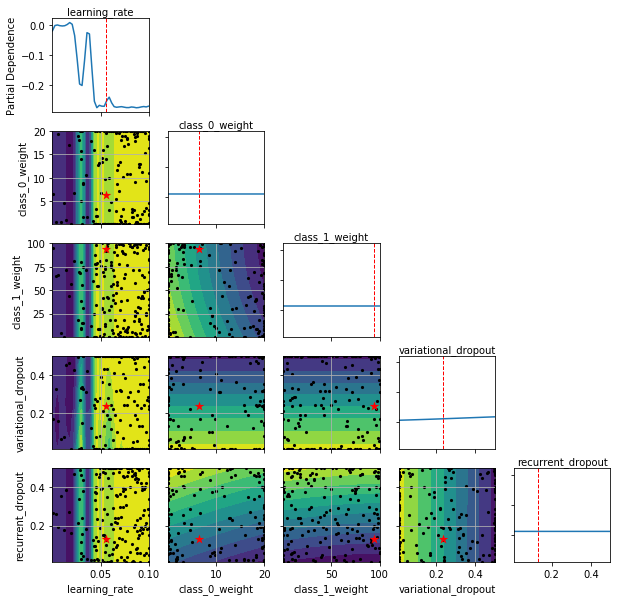

In [44]:
dim_names = [
#     'past_history',
    'learning_rate',
    'class_0_weight',
    'class_1_weight',
#     'lstm_units',
    'variational_dropout',
    'recurrent_dropout'
]

fig, ax = plot_objective(result = search_result, dimension_names = dim_names)

In [45]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.05523625223131764,
 'class_0_weight': 6.3720941191248395,
 'class_1_weight': 94.18261239534365,
 'variational_dropout': 0.237336058143935,
 'recurrent_dropout': 0.12864002272706876}

In [80]:
# hyperparameters
#learning_rate = winning_hyperparams['learning_rate']
learning_rate = 0.07
# past_history = winning_hyperparams['past_history']
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']
#lstm_units = winning_hyperparams['lstm_units']
#variational_dropout = winning_hyperparams['variational_dropout']
variational_dropout = 0.1
recurrent_dropout = winning_hyperparams['recurrent_dropout']
recurrent_dropout = 0.5
# learning_rate = 0.05
# past_history = 9
# class_0_weight = 4
# class_1_weight = 25
# lstm_units = 1
# variational_dropout = 0.48
# recurrent_dropout = 0.5

EPOCHS = 200
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [81]:
x_train, y_train = data_functions.multivariate_data(
    training_data, 
    training_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data, 
    validation_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data, 
    test_labels, 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [82]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    1,
    batch_input_shape = input_shape,
    dropout = variational_dropout,
    recurrent_dropout = recurrent_dropout,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (650, 1)                  88        
_________________________________________________________________
dense_3 (Dense)              (650, 1)                  2         
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [early_stopping_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8
    #verbose=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3250 samples, validate on 3250 samples
Epoch 1/200
3250/3250 [==============================] - 3s 1ms/sample - loss: 15.2390 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.6609 - matthews_correlation: 0.0000e+00 - val_loss: 11.6654 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7242 - val_matthews_correlation: 0.0000e+00
Epoch 2/200
3250/3250 [==============================] - 0s 49us/sample - loss: 10.9535 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 2977.0000 - false_negatives: 273.0000 - auc: 0.7013 - matthews_correlation: 0.0000e+00 - val_loss: 9.4767 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 2990.0000 - val_false_negatives: 260.0000 - val_auc: 0.7550 - val_matthews_correlat

Epoch 19/200
3250/3250 [==============================] - 0s 52us/sample - loss: 7.2511 - true_positives: 243.0000 - false_positives: 988.0000 - true_negatives: 1989.0000 - false_negatives: 30.0000 - auc: 0.8200 - matthews_correlation: 0.3193 - val_loss: 8.0476 - val_true_positives: 227.0000 - val_false_positives: 1098.0000 - val_true_negatives: 1892.0000 - val_false_negatives: 33.0000 - val_auc: 0.7859 - val_matthews_correlation: 0.2747
Epoch 20/200
3250/3250 [==============================] - 0s 50us/sample - loss: 7.1975 - true_positives: 242.0000 - false_positives: 966.0000 - true_negatives: 2011.0000 - false_negatives: 31.0000 - auc: 0.8274 - matthews_correlation: 0.3220 - val_loss: 8.0893 - val_true_positives: 231.0000 - val_false_positives: 1103.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 29.0000 - val_auc: 0.7859 - val_matthews_correlation: 0.2833
Epoch 21/200
3250/3250 [==============================] - 0s 50us/sample - loss: 7.1943 - true_positives: 244.0000 -

Epoch 56/200
3250/3250 [==============================] - 0s 50us/sample - loss: 6.9194 - true_positives: 243.0000 - false_positives: 958.0000 - true_negatives: 2019.0000 - false_negatives: 30.0000 - auc: 0.8406 - matthews_correlation: 0.3248 - val_loss: 8.3074 - val_true_positives: 230.0000 - val_false_positives: 1162.0000 - val_true_negatives: 1828.0000 - val_false_negatives: 30.0000 - val_auc: 0.7886 - val_matthews_correlation: 0.2695
Epoch 57/200
3250/3250 [==============================] - 0s 49us/sample - loss: 6.9250 - true_positives: 242.0000 - false_positives: 992.0000 - true_negatives: 1985.0000 - false_negatives: 31.0000 - auc: 0.8414 - matthews_correlation: 0.3158 - val_loss: 8.2841 - val_true_positives: 233.0000 - val_false_positives: 1192.0000 - val_true_negatives: 1798.0000 - val_false_negatives: 27.0000 - val_auc: 0.7907 - val_matthews_correlation: 0.2698
Epoch 58/200
3250/3250 [==============================] - 0s 50us/sample - loss: 6.9030 - true_positives: 249.0000 -

Epoch 93/200
3250/3250 [==============================] - 0s 51us/sample - loss: 6.8088 - true_positives: 249.0000 - false_positives: 985.0000 - true_negatives: 1992.0000 - false_negatives: 24.0000 - auc: 0.8412 - matthews_correlation: 0.3312 - val_loss: 8.5646 - val_true_positives: 231.0000 - val_false_positives: 1204.0000 - val_true_negatives: 1786.0000 - val_false_negatives: 29.0000 - val_auc: 0.7835 - val_matthews_correlation: 0.2654
Epoch 94/200
3250/3250 [==============================] - 0s 52us/sample - loss: 6.8153 - true_positives: 245.0000 - false_positives: 965.0000 - true_negatives: 2012.0000 - false_negatives: 28.0000 - auc: 0.8414 - matthews_correlation: 0.3297 - val_loss: 8.5821 - val_true_positives: 230.0000 - val_false_positives: 1191.0000 - val_true_negatives: 1799.0000 - val_false_negatives: 30.0000 - val_auc: 0.7843 - val_matthews_correlation: 0.2656
Epoch 95/200
3250/3250 [==============================] - 0s 50us/sample - loss: 6.9015 - true_positives: 247.0000 -

3250/3250 [==============================] - 0s 49us/sample - loss: 6.8235 - true_positives: 247.0000 - false_positives: 954.0000 - true_negatives: 2023.0000 - false_negatives: 26.0000 - auc: 0.8411 - matthews_correlation: 0.3353 - val_loss: 8.8558 - val_true_positives: 229.0000 - val_false_positives: 1219.0000 - val_true_negatives: 1771.0000 - val_false_negatives: 31.0000 - val_auc: 0.7805 - val_matthews_correlation: 0.2573
Epoch 130/200
3250/3250 [==============================] - 0s 48us/sample - loss: 6.7903 - true_positives: 245.0000 - false_positives: 939.0000 - true_negatives: 2038.0000 - false_negatives: 28.0000 - auc: 0.8423 - matthews_correlation: 0.3351 - val_loss: 8.8630 - val_true_positives: 231.0000 - val_false_positives: 1224.0000 - val_true_negatives: 1766.0000 - val_false_negatives: 29.0000 - val_auc: 0.7820 - val_matthews_correlation: 0.2602
Epoch 131/200
3250/3250 [==============================] - 0s 50us/sample - loss: 6.6893 - true_positives: 249.0000 - false_posi

3250/3250 [==============================] - 0s 54us/sample - loss: 6.8345 - true_positives: 246.0000 - false_positives: 967.0000 - true_negatives: 2010.0000 - false_negatives: 27.0000 - auc: 0.8432 - matthews_correlation: 0.3304 - val_loss: 8.9800 - val_true_positives: 231.0000 - val_false_positives: 1209.0000 - val_true_negatives: 1781.0000 - val_false_negatives: 29.0000 - val_auc: 0.7850 - val_matthews_correlation: 0.2639
Epoch 166/200
3250/3250 [==============================] - 0s 53us/sample - loss: 6.7876 - true_positives: 243.0000 - false_positives: 1007.0000 - true_negatives: 1970.0000 - false_negatives: 30.0000 - auc: 0.8411 - matthews_correlation: 0.3149 - val_loss: 8.9864 - val_true_positives: 232.0000 - val_false_positives: 1223.0000 - val_true_negatives: 1767.0000 - val_false_negatives: 28.0000 - val_auc: 0.7844 - val_matthews_correlation: 0.2627
Epoch 167/200
3250/3250 [==============================] - 0s 52us/sample - loss: 6.8739 - true_positives: 240.0000 - false_pos

Total observations: 3287


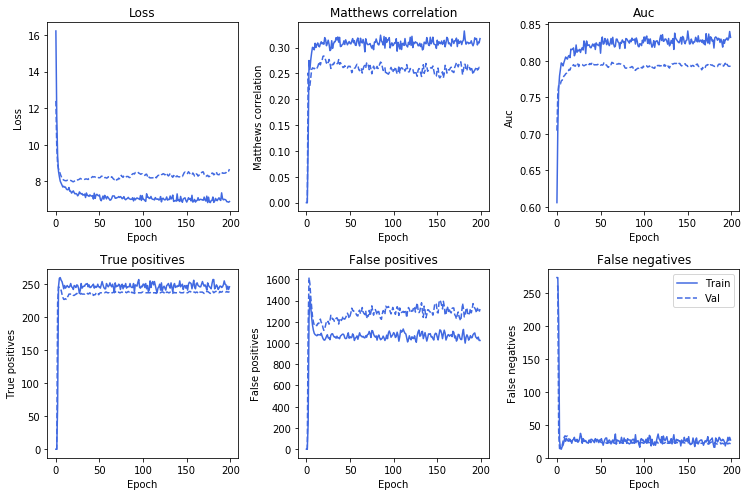

In [73]:
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../../figures/single_LSTM_learning_curves_CA_only.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [74]:
train_predictions = model.predict(x_train)
validation_predictions = model.predict(x_validation)
test_predictions = model.predict(x_testing)

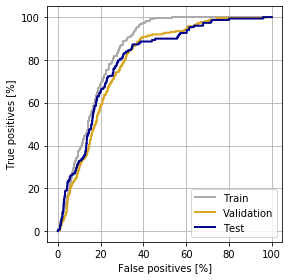

In [75]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

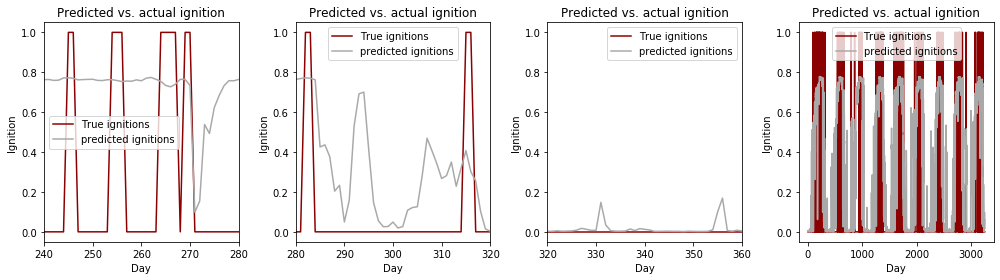

In [76]:
filename = '../../figures/single_statefull_LSTM_training_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

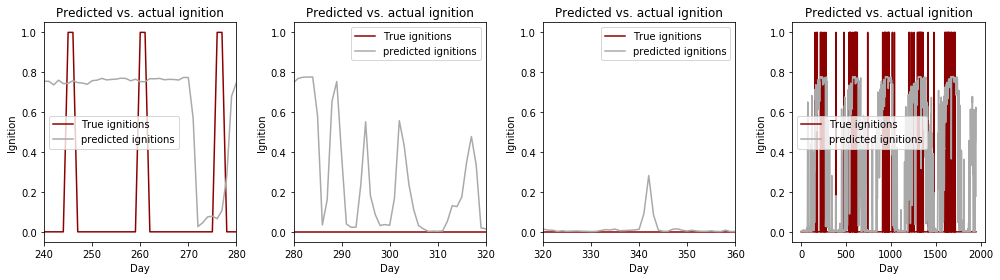

In [77]:
filename = '../../figures/single_statefull_LSTM_testing_predictions_CA_only.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)

loss :  0.5040434122085571
true_positives :  260.0
false_positives :  1089.0
true_negatives :  1888.0
false_negatives :  13.0
auc :  0.8413348
matthews_correlation :  0.32455534
No fire (True Negatives):  1882
False alarms (False Positives):  1095
Fires missed (False Negatives):  14
Fires detected (True Positives):  259
Total fires:  273


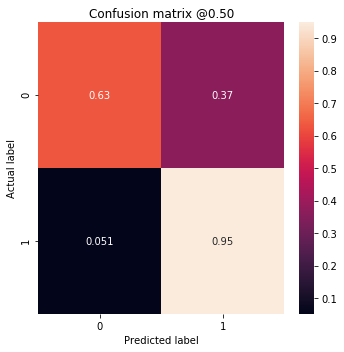

In [78]:
results = model.evaluate(
    x_train,
    y_train, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_train, train_predictions)

loss :  0.571256697177887
true_positives :  132.0
false_positives :  732.0
true_negatives :  1069.0
false_negatives :  17.0
auc :  0.8001949
matthews_correlation :  0.2530156
No fire (True Negatives):  1069
False alarms (False Positives):  732
Fires missed (False Negatives):  17
Fires detected (True Positives):  132
Total fires:  149


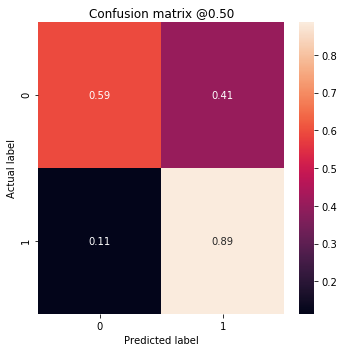

In [79]:
results = model.evaluate(
    x_testing,
    y_testing, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plotting_functions.plot_cm(y_testing, test_predictions)